In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data
from algorithms import fixed_bitwidth
from model_gen import keras_cnn
from algorithms.optimized_search import OptimizedSearch

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd
import pickle

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


## Dependent Optimized Search quantization

In [2]:
input_shape = (28, 28, 1)
num_outputs = 10
num_kernels = 32
num_stages = 7
path_trained_weights = 'C:/Users/320060820/experiments/test_models/fashion_keras/fashion_seq_large_w.h5'
output_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/F Sequential L Fashion/'
name = 'fashion_seq_large'

from test_models.fashion_keras import data
_, test_data = data.get_data()

model_arch = keras_cnn.KerasCNNLarge(input_shape, num_outputs, num_kernels, num_stages, pool_layer_interval = 2, 
                                     path_trained_weights = path_trained_weights)
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
float_model_acc = model_obj.evaluate_accuracy()[1]
print(float_model_acc)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
0.9247


In [3]:
layer_names = [layer.name for layer in model_obj.model.layers if layer.name.startswith('conv2d') or \
               layer.name.startswith('dense')]
print(layer_names)

['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_6', 'conv2d_7', 'conv2d_8', 'conv2d_9', 'conv2d_10', 'conv2d_11', 'conv2d_12', 'conv2d_13', 'conv2d_14', 'dense_1']


### Function design for allocating accuracy drops per layer

In [4]:
total_acc_drop = 0.005
# Functions
# x: layer index
# n: total accuracy drop
# s: scale/number of layers
linear = lambda x, n, s: n/s * x
quadratic = lambda x, n, s: n/s**2 * x**2
cubic = lambda x, n, s: n/s**3 * x**3
exponential = lambda x, n, s: n/2**s * 2**x
log = lambda x, n, s: n/np.log(s) * np.log(x)
alloc_types = ['constant', 'linear', 'quadratic', 'cubic', 'exponential', 'log']

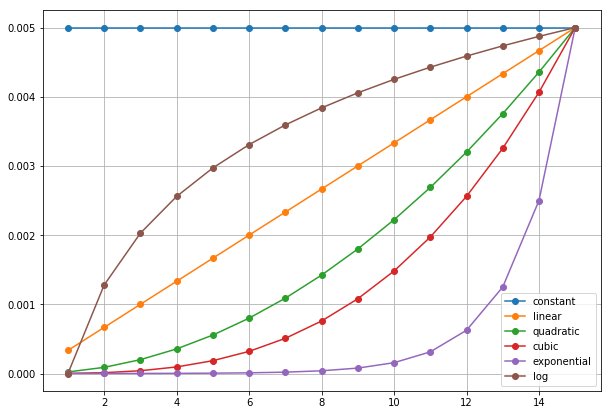

In [5]:
x = np.arange(1, len(layer_names) + 1, 1)
num_layers = len(x)
n = 0.005 # loss of 0.5%
y1 = np.ones(x.shape) * n # constant
y2 = linear(x, n, num_layers)
y3 = quadratic(x, n, num_layers) # Quadratic
y4 = cubic(x, n, num_layers) # Cubic
y5 = exponential(x, n, num_layers) # Exponential
y6 = log(x, n, num_layers) # log

plt.figure(figsize=(10, 7))
plt.plot(x, y1, 'o-', label='constant');
plt.plot(x, y2, 'o-', label='linear');
plt.plot(x, y3, 'o-', label='quadratic');
plt.plot(x, y4, 'o-', label='cubic');
plt.plot(x, y5, 'o-', label='exponential');
plt.plot(x, y6, 'o-', label='log');
plt.grid();
plt.legend();

In [6]:
start_bw = 11
w_scores = {}
opt_params_weights = {}
acc_drop_w = {}

#### Constant

In [7]:
alloc_type = 'constant'
acc_drop_config = {
    layer: total_acc_drop for layer in layer_names
}
opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
w_scores[alloc_type], opt_params_weights[alloc_type], acc_drop_w[alloc_type] = opts.run('weights', start_bw = start_bw)

{'conv2d_1': [11, 11], 'conv2d_2': [11, 12], 'conv2d_3': [11, 12], 'conv2d_4': [11, 12], 'conv2d_5': [11, 12], 'conv2d_6': [11, 12], 'conv2d_7': [11, 12], 'conv2d_8': [11, 13], 'conv2d_9': [11, 12], 'conv2d_10': [11, 12], 'conv2d_11': [11, 13], 'conv2d_12': [11, 12], 'conv2d_13': [11, 12], 'conv2d_14': [11, 12], 'dense_1': [11, 11]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer conv2d_1
(6, 7) (6, 7) 0.0
Chosen:  (6, 7)
After quantizing layer conv2d_1 | Measured accuracy drop 0.00010814318157238995 | Acceptable accuracy drop: 0.005
Quantizing layer conv2d_2
(4, 5) (5, 6) 0.0017302909051584792
Chosen:  (5, 6)
After quantizing layer conv2d_2 | Measured accuracy drop 0.0014058613604411895 | Acceptable accuracy drop: 0.005
Quantizing layer conv2d_3
(3, 4) (3, 4) 0.0
Chosen:  (3, 4)
After quantizing layer conv2d_3 | Measured accuracy drop 0.003568724991889229 | Acceptable accuracy drop: 0.005
Quantizing layer conv2d_4
(4, 6) (5, 6) 0.0007

In [10]:
if not isinstance(opt_params_weights[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')
    model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights[alloc_type])
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(w_scores[alloc_type], 5, 3, (20, 30))

Floating point model accuracy: 92.470 %


#### Log

In [19]:
alloc_type = 'log'

acc_drop_config = {
    layer_names[i - 1]: log(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
w_scores[alloc_type], opt_params_weights[alloc_type], acc_drop_w[alloc_type] = opts.run('weights', start_bw = start_bw)

{'conv2d_1': [11, 11], 'conv2d_2': [11, 12], 'conv2d_3': [11, 12], 'conv2d_4': [11, 12], 'conv2d_5': [11, 12], 'conv2d_6': [11, 12], 'conv2d_7': [11, 12], 'conv2d_8': [11, 13], 'conv2d_9': [11, 12], 'conv2d_10': [11, 12], 'conv2d_11': [11, 13], 'conv2d_12': [11, 12], 'conv2d_13': [11, 12], 'conv2d_14': [11, 12], 'dense_1': [11, 11]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer conv2d_1
(9, 10) (9, 10) 0.0
Chosen:  (9, 10)
After quantizing layer conv2d_1 | Measured accuracy drop 0.0 | Acceptable accuracy drop: 0.0
Quantizing layer conv2d_2
(4, 6) (4, 6) 0.0
Chosen:  (4, 6)
After quantizing layer conv2d_2 | Measured accuracy drop -0.0005407159078620698 | Acceptable accuracy drop: 0.0012797901240490775
Quantizing layer conv2d_3
(3, 4) (4, 5) 0.00010814318157238993
Chosen:  (3, 4)
After quantizing layer conv2d_3 | Measured accuracy drop 0.0014058613604411895 | Acceptable accuracy drop: 0.002028419355411065
Quantizing layer conv2d_4
(4, 

Floating point model accuracy: 92.470 %
Quantized model accuracy: 92.060 %
Accuracy drop of 0.443 %


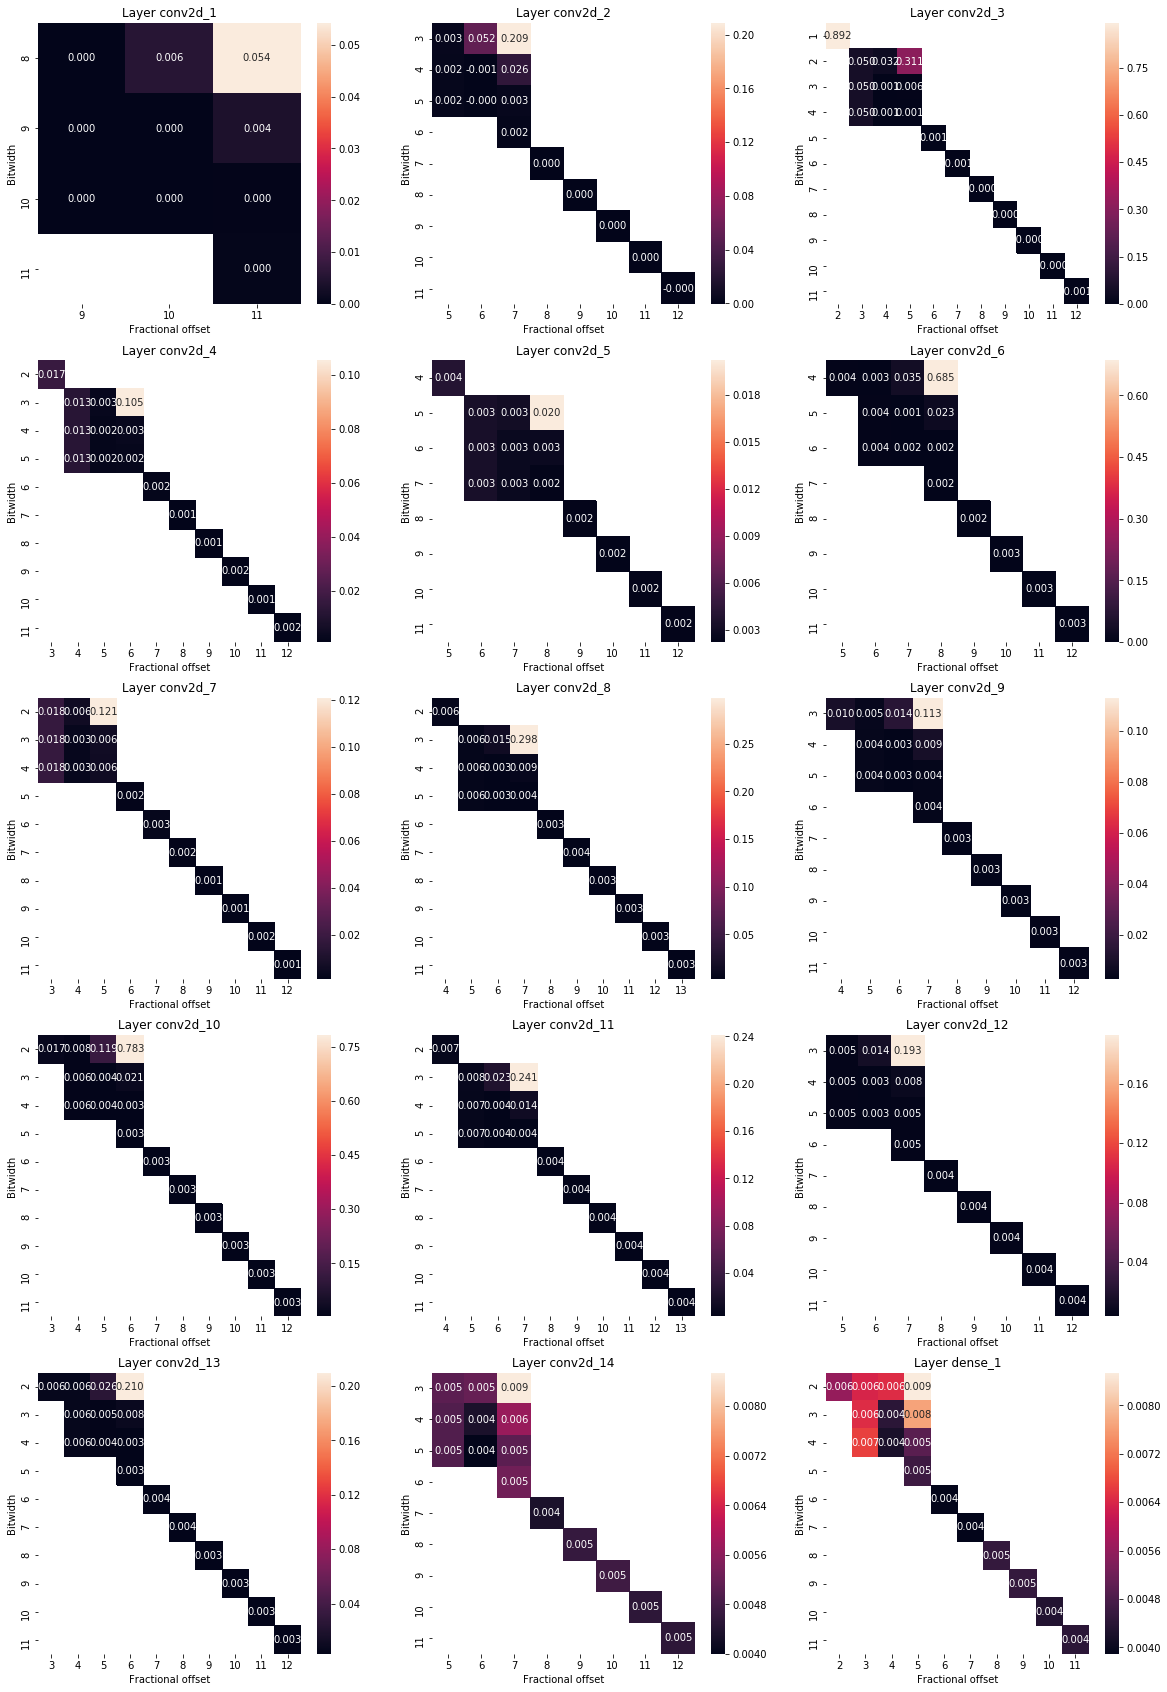

In [20]:
if not isinstance(opt_params_weights[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights[alloc_type])
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(w_scores[alloc_type], 5, 3, (20, 30))

#### Linear

In [11]:
alloc_type = 'linear'

acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
w_scores[alloc_type], opt_params_weights[alloc_type], acc_drop_w[alloc_type] = opts.run('weights', start_bw = start_bw)

{'conv2d_1': [11, 11], 'conv2d_2': [11, 12], 'conv2d_3': [11, 12], 'conv2d_4': [11, 12], 'conv2d_5': [11, 12], 'conv2d_6': [11, 12], 'conv2d_7': [11, 12], 'conv2d_8': [11, 13], 'conv2d_9': [11, 12], 'conv2d_10': [11, 12], 'conv2d_11': [11, 13], 'conv2d_12': [11, 12], 'conv2d_13': [11, 12], 'conv2d_14': [11, 12], 'dense_1': [11, 11]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer conv2d_1
(9, 10) (9, 10) 0.0
Chosen:  (9, 10)
After quantizing layer conv2d_1 | Measured accuracy drop 0.0 | Acceptable accuracy drop: 0.0003333333333333333
Quantizing layer conv2d_2
(4, 6) (4, 6) 0.0
Chosen:  (4, 6)
After quantizing layer conv2d_2 | Measured accuracy drop -0.0005407159078620698 | Acceptable accuracy drop: 0.0006666666666666666
Quantizing layer conv2d_3
(5, 6) (6, 7) 0.0018384340867307492
Chosen:  (6, 7)
After quantizing layer conv2d_3 | Measured accuracy drop -0.0010814318157240197 | Acceptable accuracy drop: 0.001
Quantizing layer conv2d_4
(

Floating point model accuracy: 92.470 %
Quantized model accuracy: 92.230 %
Accuracy drop of 0.260 %


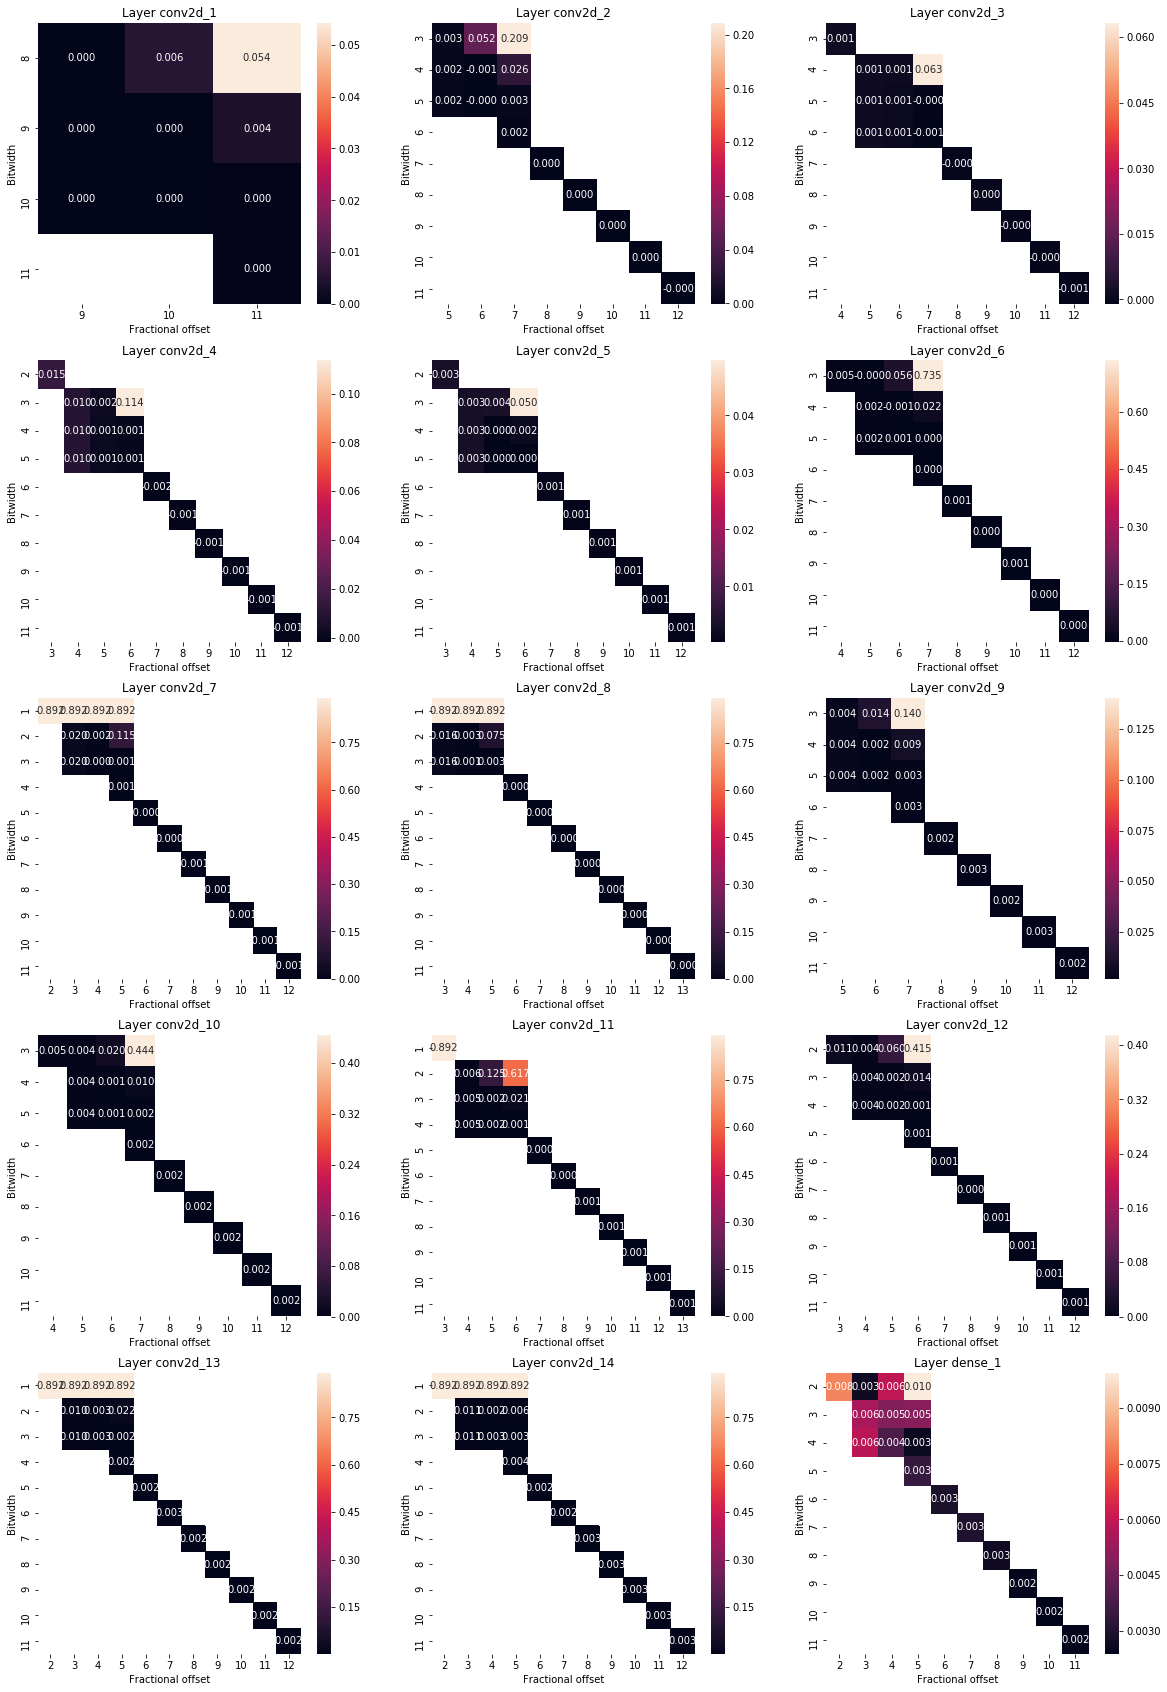

In [12]:
if not isinstance(opt_params_weights[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights[alloc_type])
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(w_scores[alloc_type], 5, 3, (20, 30))

#### Quadratic

In [13]:
alloc_type = 'quadratic'

acc_drop_config = {
    layer_names[i - 1]: quadratic(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
w_scores[alloc_type], opt_params_weights[alloc_type], acc_drop_w[alloc_type] = opts.run('weights', start_bw = start_bw)

{'conv2d_1': [11, 11], 'conv2d_2': [11, 12], 'conv2d_3': [11, 12], 'conv2d_4': [11, 12], 'conv2d_5': [11, 12], 'conv2d_6': [11, 12], 'conv2d_7': [11, 12], 'conv2d_8': [11, 13], 'conv2d_9': [11, 12], 'conv2d_10': [11, 12], 'conv2d_11': [11, 13], 'conv2d_12': [11, 12], 'conv2d_13': [11, 12], 'conv2d_14': [11, 12], 'dense_1': [11, 11]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer conv2d_1
(9, 10) (9, 10) 0.0
Chosen:  (9, 10)
After quantizing layer conv2d_1 | Measured accuracy drop 0.0 | Acceptable accuracy drop: 2.2222222222222223e-05
Quantizing layer conv2d_2
(10, 11) (11, 12) 0.00010814318157238995
Chosen:  (10, 11)
After quantizing layer conv2d_2 | Measured accuracy drop 0.0 | Acceptable accuracy drop: 8.888888888888889e-05
Quantizing layer conv2d_3
(7, 8) (7, 8) 0.0
Chosen:  (7, 8)
After quantizing layer conv2d_3 | Measured accuracy drop -0.00021628636314489997 | Acceptable accuracy drop: 0.0002
Quantizing layer conv2d_4
(5, 7) (5,

Floating point model accuracy: 92.470 %
Quantized model accuracy: 92.350 %
Accuracy drop of 0.130 %


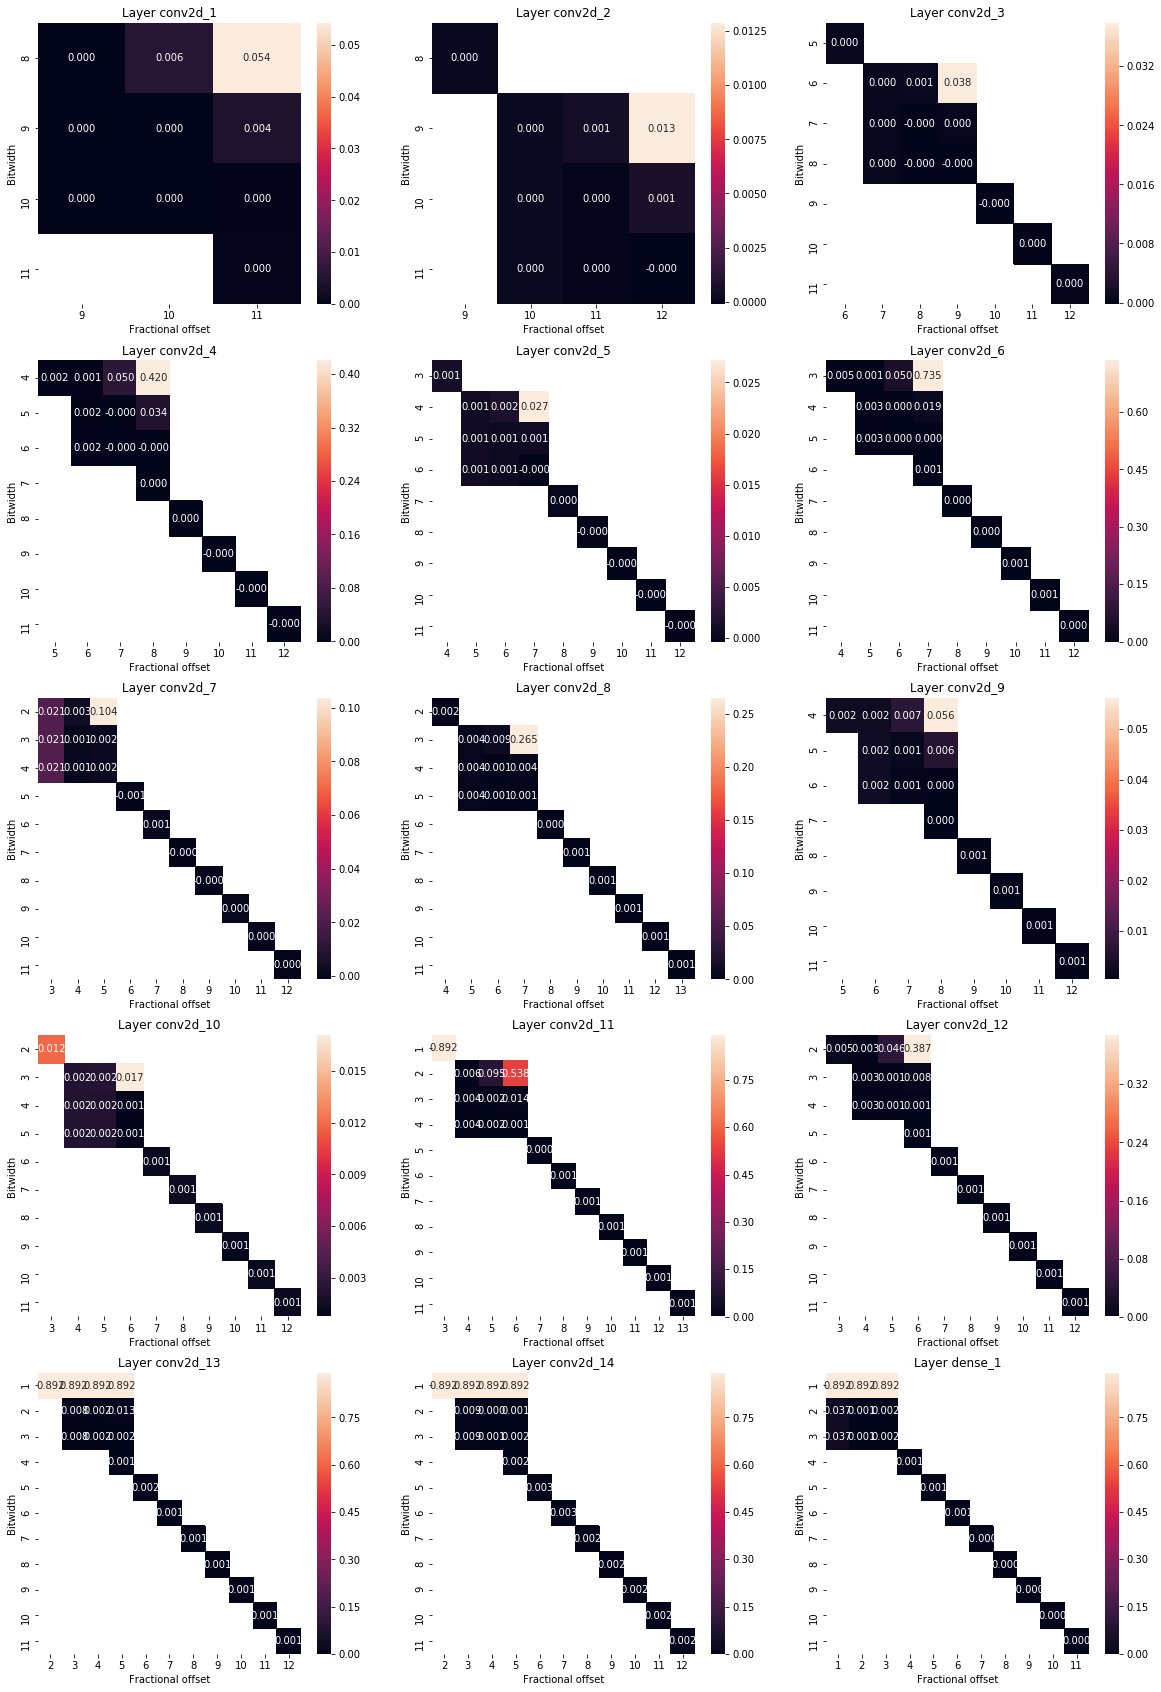

In [14]:
if not isinstance(opt_params_weights[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights[alloc_type])
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(w_scores[alloc_type], 5, 3, (20, 30))

#### Cubic

In [15]:
alloc_type = 'cubic'

acc_drop_config = {
    layer_names[i - 1]: cubic(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
w_scores[alloc_type], opt_params_weights[alloc_type], acc_drop_w[alloc_type] = opts.run('weights', start_bw = 12)

{'conv2d_1': [12, 12], 'conv2d_2': [12, 13], 'conv2d_3': [12, 13], 'conv2d_4': [12, 13], 'conv2d_5': [12, 13], 'conv2d_6': [12, 13], 'conv2d_7': [12, 13], 'conv2d_8': [12, 14], 'conv2d_9': [12, 13], 'conv2d_10': [12, 13], 'conv2d_11': [12, 14], 'conv2d_12': [12, 13], 'conv2d_13': [12, 13], 'conv2d_14': [12, 13], 'dense_1': [12, 12]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer conv2d_1
(9, 10) (9, 10) 0.0
Chosen:  (9, 10)
After quantizing layer conv2d_1 | Measured accuracy drop 0.0 | Acceptable accuracy drop: 1.4814814814814815e-06
Quantizing layer conv2d_2
(11, 12) (11, 12) 0.0
Chosen:  (11, 12)
After quantizing layer conv2d_2 | Measured accuracy drop -0.00010814318157238995 | Acceptable accuracy drop: 1.1851851851851852e-05
Quantizing layer conv2d_3
(7, 8) (7, 8) 0.0
Chosen:  (7, 8)
After quantizing layer conv2d_3 | Measured accuracy drop -0.00010814318157238995 | Acceptable accuracy drop: 3.9999999999999996e-05
Quantizing layer c

Floating point model accuracy: 92.470 %
Quantized model accuracy: 92.530 %
Accuracy drop of -0.065 %


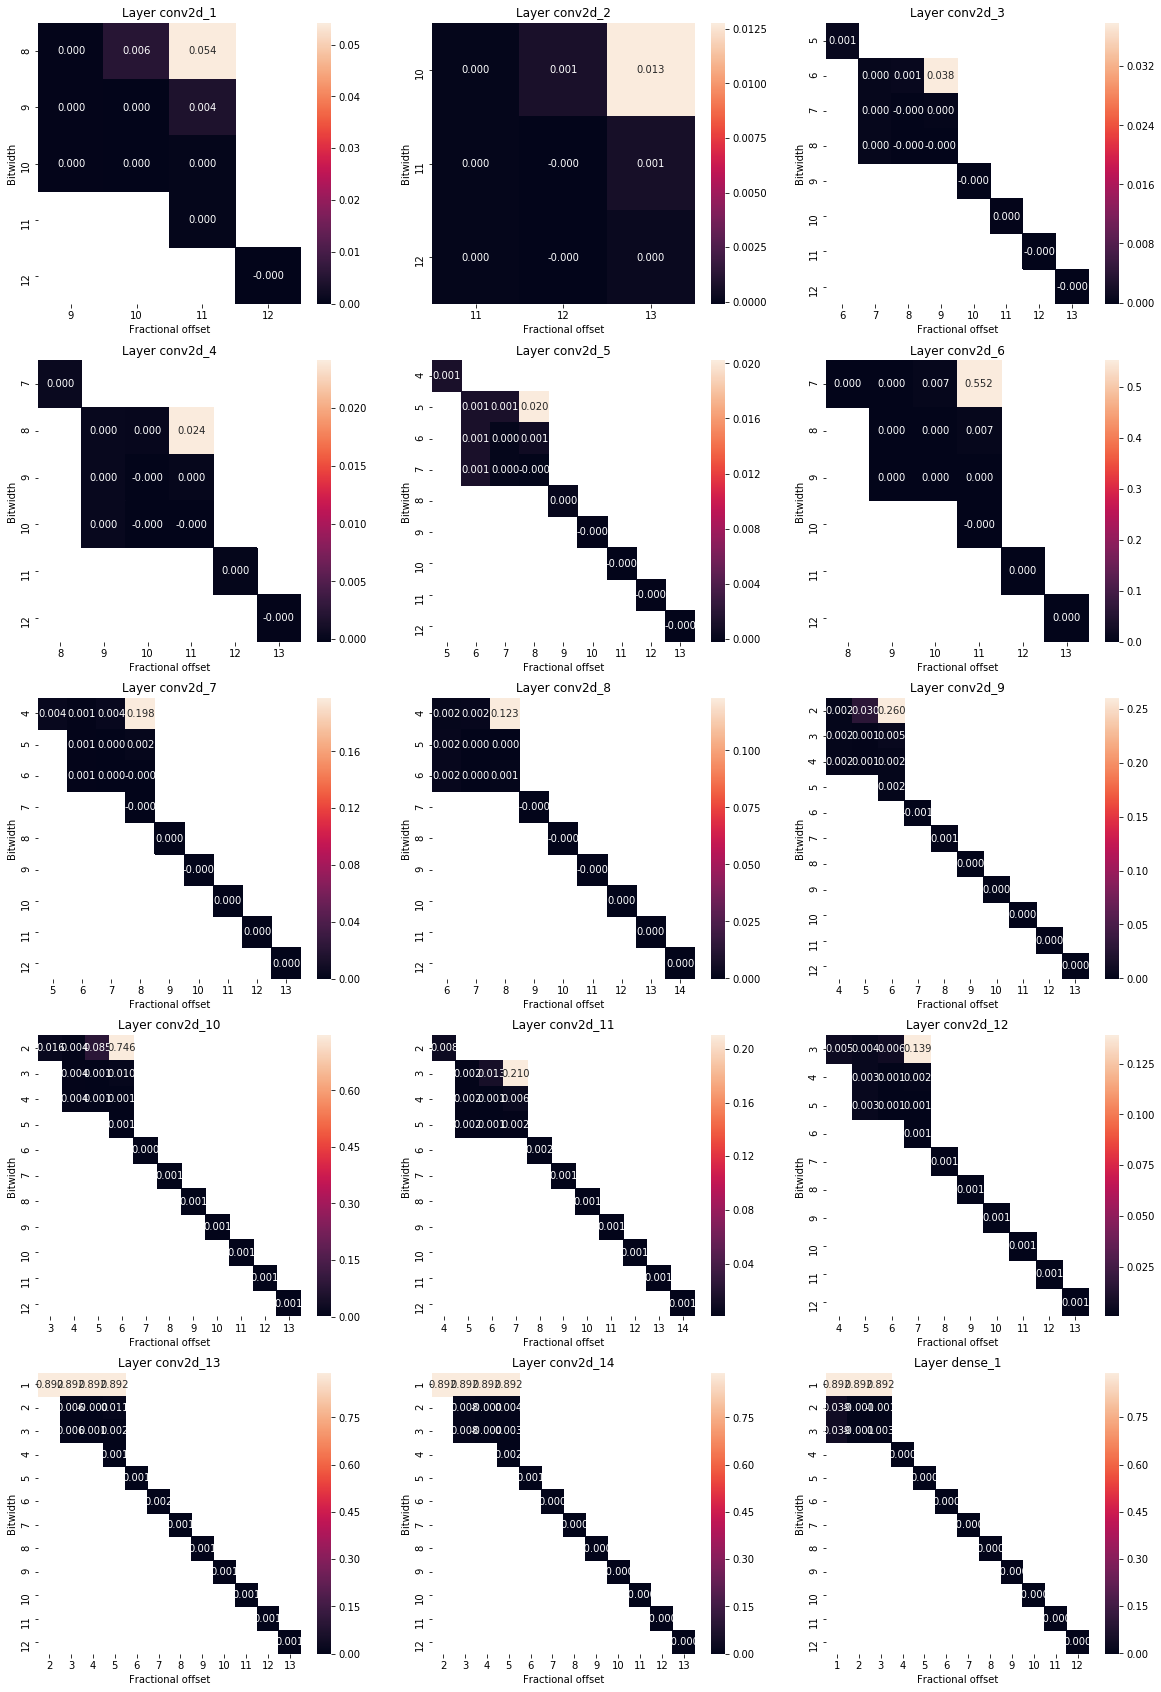

In [16]:
if not isinstance(opt_params_weights[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights[alloc_type])
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(w_scores[alloc_type], 5, 3, (20, 30))

#### Exponential

In [17]:
alloc_type = 'exponential'

acc_drop_config = {
    layer_names[i - 1]: exponential(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
w_scores[alloc_type], opt_params_weights[alloc_type], acc_drop_w[alloc_type] = opts.run('weights', start_bw = 12)

{'conv2d_1': [12, 12], 'conv2d_2': [12, 13], 'conv2d_3': [12, 13], 'conv2d_4': [12, 13], 'conv2d_5': [12, 13], 'conv2d_6': [12, 13], 'conv2d_7': [12, 13], 'conv2d_8': [12, 14], 'conv2d_9': [12, 13], 'conv2d_10': [12, 13], 'conv2d_11': [12, 14], 'conv2d_12': [12, 13], 'conv2d_13': [12, 13], 'conv2d_14': [12, 13], 'dense_1': [12, 12]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer conv2d_1
(9, 10) (9, 10) 0.0
Chosen:  (9, 10)
After quantizing layer conv2d_1 | Measured accuracy drop 0.0 | Acceptable accuracy drop: 3.0517578125e-07
Quantizing layer conv2d_2
(11, 12) (11, 12) 0.0
Chosen:  (11, 12)
After quantizing layer conv2d_2 | Measured accuracy drop -0.00010814318157238995 | Acceptable accuracy drop: 6.103515625e-07
Quantizing layer conv2d_3
(7, 8) (7, 8) 0.0
Chosen:  (7, 8)
After quantizing layer conv2d_3 | Measured accuracy drop -0.00010814318157238995 | Acceptable accuracy drop: 1.220703125e-06
Quantizing layer conv2d_4
(9, 10) (9, 

Floating point model accuracy: 92.470 %
Quantized model accuracy: 92.540 %
Accuracy drop of -0.076 %


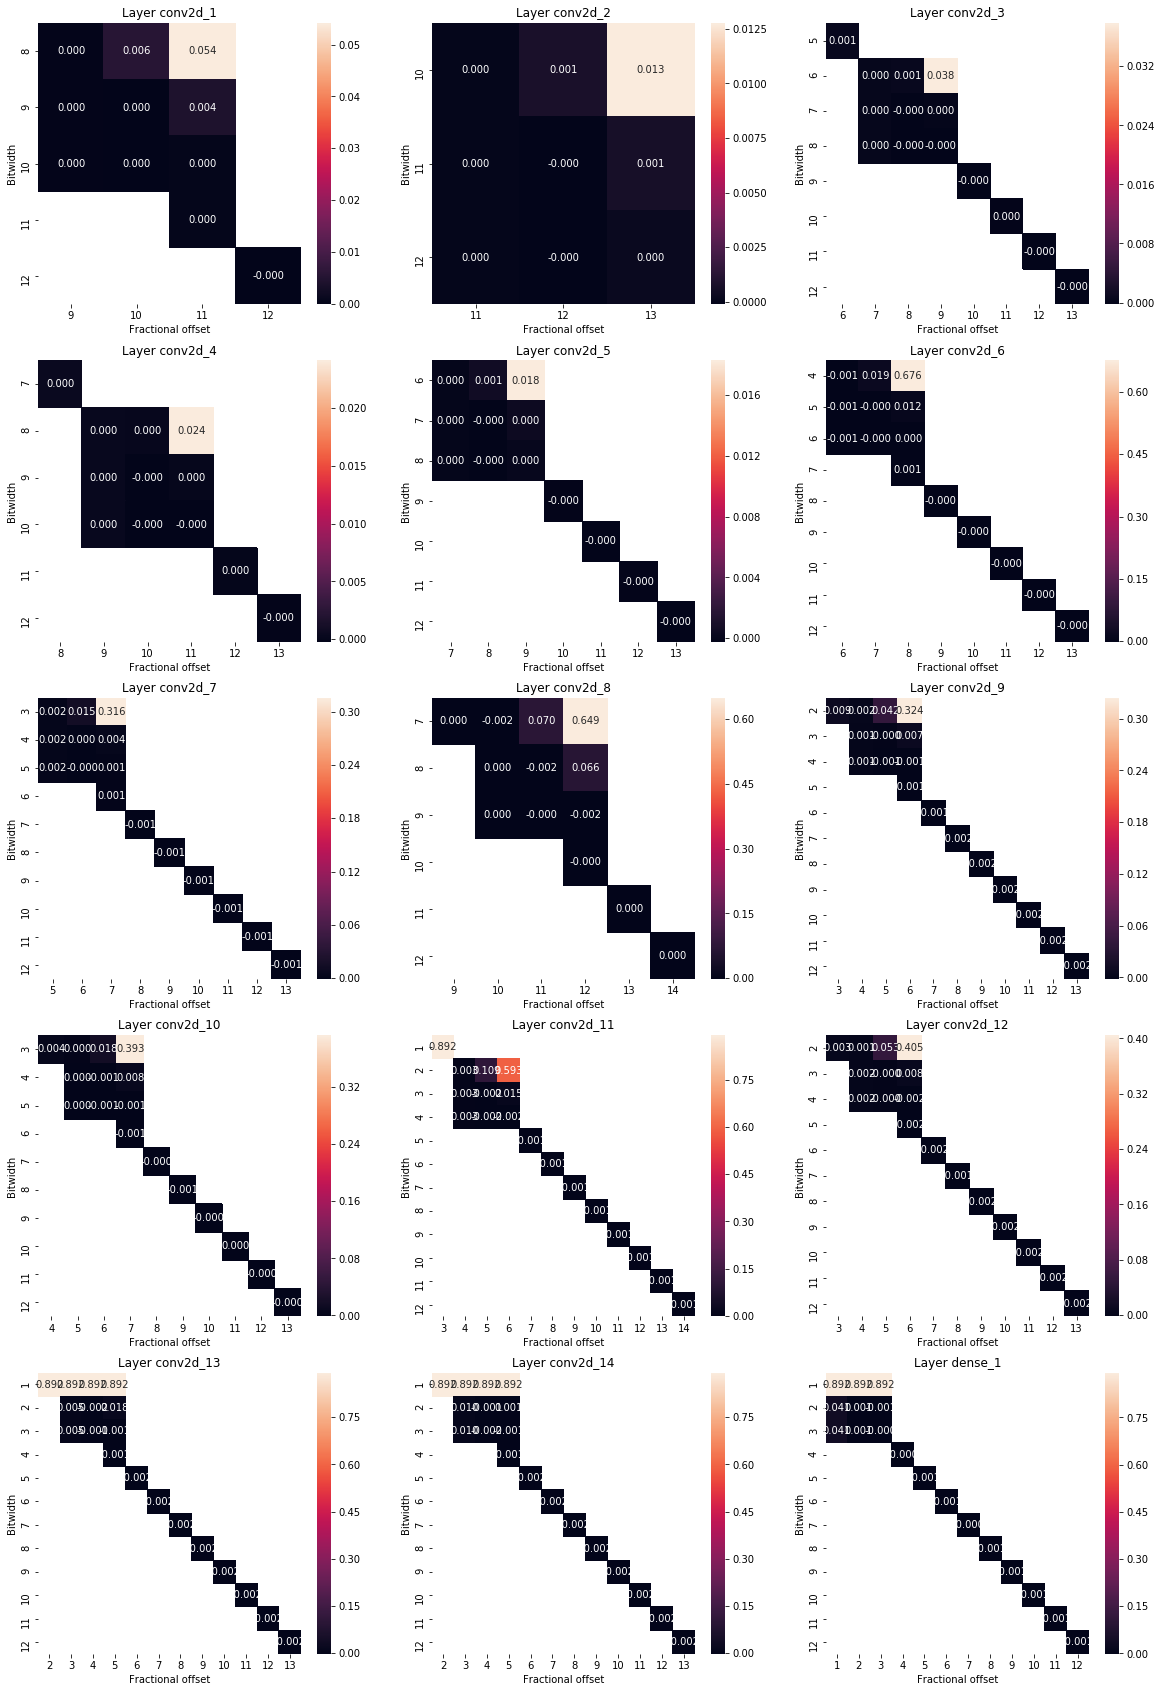

In [18]:
if not isinstance(opt_params_weights[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights[alloc_type])
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(w_scores[alloc_type], 5, 3, (20, 30))

In [24]:
with open(output_path + 'fixed/w_scores.p', 'wb') as f:
    pickle.dump(w_scores, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(output_path + 'fixed/opt_params_w.p', 'wb') as f:
    pickle.dump(opt_params_weights, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(output_path + 'fixed/acc_drop_w.p', 'wb') as f:
    pickle.dump(acc_drop_w, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(output_path + 'w_scores.p', 'wb') as f:
    pickle.dump(w_scores, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(output_path + 'opt_params_w.p', 'wb') as f:
    pickle.dump(opt_params_weights, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(output_path + 'acc_drop_w.p', 'wb') as f:
    pickle.dump(acc_drop_w, f, protocol=pickle.HIGHEST_PROTOCOL)

## Observing results for the types of allocations

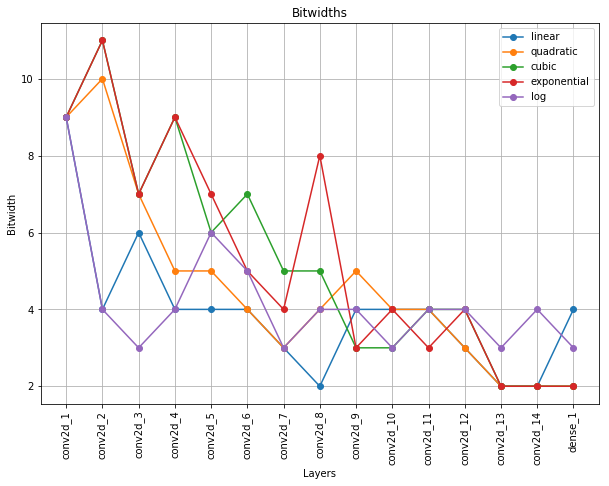

In [28]:
## Bitwidths
x = np.arange(1, len(layer_names) + 1, 1)

plt.figure(figsize=(10, 7))
for k in opt_params_weights:
    if isinstance(opt_params_weights[k], int):
        continue
    bw = [opt_params_weights[k][layer][0] for layer in opt_params_weights[k]]
    plt.plot(x, bw, 'o-', label=k)
plt.xticks(x, layer_names, rotation='vertical')
plt.title('Bitwidths')
plt.xlabel('Layers');
plt.ylabel('Bitwidth');
plt.grid()
plt.legend();

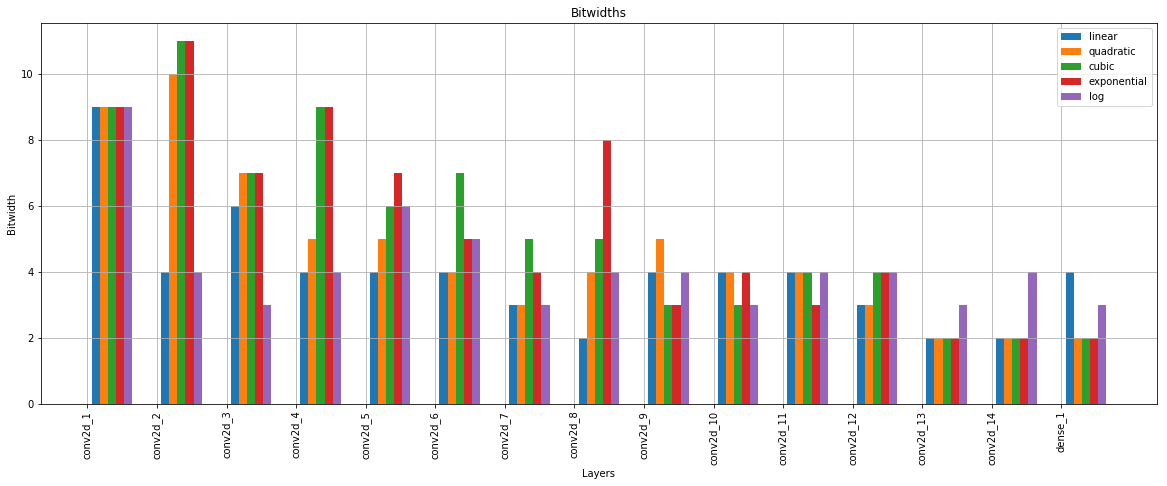

In [29]:
plt.figure(figsize=(20, 7))
width = 0.35
x = np.arange(1, 3*len(layer_names) + 1, 3)
for j, k in enumerate(opt_params_weights.keys()):
    if isinstance(opt_params_weights[k], int):
        continue
    bw = [opt_params_weights[k][layer][0] for layer in opt_params_weights[k]]
    plt.bar([i + j*width for i in x], bw, width, label=k)
plt.xticks(x, layer_names, rotation='vertical')
plt.title('Bitwidths')
plt.xlabel('Layers');
plt.ylabel('Bitwidth');
plt.grid()
plt.legend();

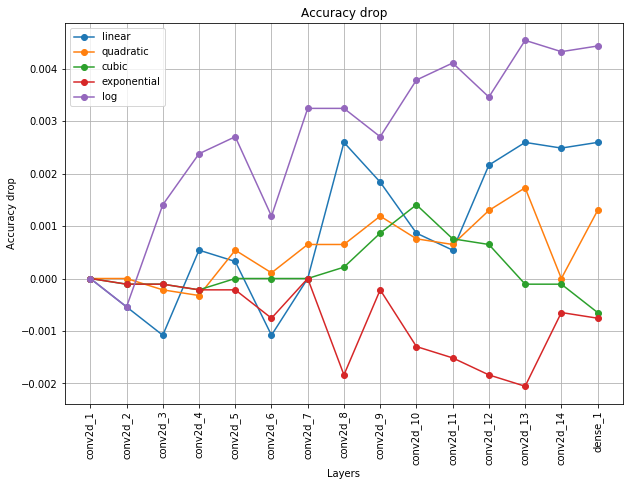

In [30]:
## Accuracy drop
x = np.arange(1, len(layer_names) + 1, 1)

plt.figure(figsize=(10, 7))
for k in acc_drop_w:
    if isinstance(acc_drop_w[k], int):
        continue
    plt.plot(x, acc_drop_w[k].values(), 'o-', label=k)
plt.title('Accuracy drop');
plt.xlabel('Layers');
plt.ylabel('Accuracy drop');
plt.xticks(x, layer_names, rotation='vertical');
plt.grid()
plt.legend();

No handles with labels found to put in legend.


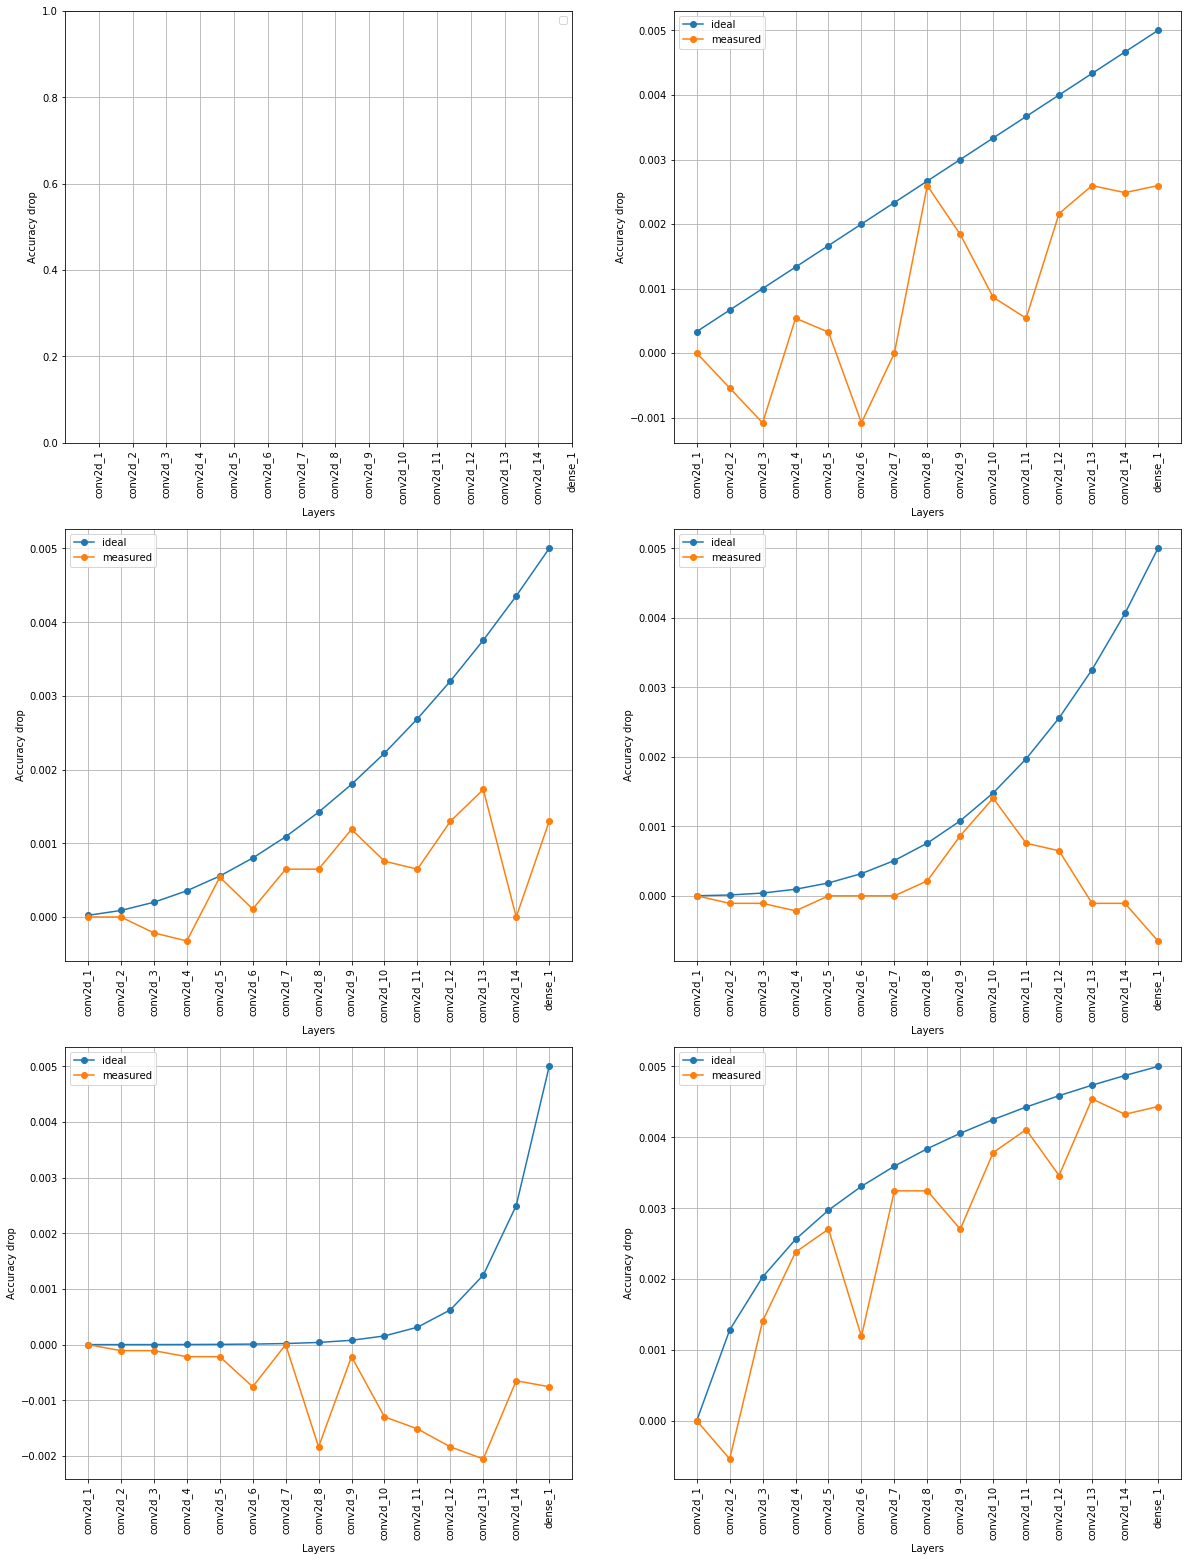

In [31]:
x = np.arange(1, 16, 1)
num_layers = len(x)
n = 0.005 # loss of 0.5%
y1 = np.ones(x.shape) * n # constant
y2 = n/num_layers * x
y3 = n/num_layers**2 * x**2 # Quadratic
y4 = n/num_layers**3 * x**3 # Cubic
y5 = n/2**num_layers * 2**x # Exponential
y6 = n/np.log(num_layers) * np.log(x) # log

fig, axes = plt.subplots(3, 2, figsize=(20, 27))
ax = axes.flatten()
# ax[0].plot(x, y1, 'o-', label='ideal');
# ax[0].plot(x, acc_drop_w['constant'].values(), 'o-', label='measured');

ax[1].plot(x, y2, 'o-', label='ideal');
ax[1].plot(x, acc_drop_w['linear'].values(), 'o-', label='measured');

ax[2].plot(x, y3, 'o-', label='ideal');
ax[2].plot(x, acc_drop_w['quadratic'].values(), 'o-', label='measured');

ax[3].plot(x, y4, 'o-', label='ideal');
ax[3].plot(x, acc_drop_w['cubic'].values(), 'o-', label='measured');

ax[4].plot(x, y5, 'o-', label='ideal');
ax[4].plot(x, acc_drop_w['exponential'].values(), 'o-', label='measured');

ax[5].plot(x, y6, 'o-', label='ideal');
ax[5].plot(x, acc_drop_w['log'].values(), 'o-', label='measured');

for i in range(6):
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(layer_names, rotation=90)
    # plt.title('Accuracy drop');
    ax[i].set_xlabel('Layers');
    ax[i].set_ylabel('Accuracy drop');
    ax[i].grid();
    ax[i].legend();

In [32]:
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())

In [33]:
num_params = []
for layer in model_obj.model.layers:
    if layer.weights and layer.name.startswith('conv2d') or layer.name.startswith('dense'):
        w = layer.get_weights()[0]
        num_weights = len(w.flatten())
        print(layer.name, num_weights)
        num_params.append(num_weights)

conv2d_1 288
conv2d_2 9216
conv2d_3 9216
conv2d_4 9216
conv2d_5 9216
conv2d_6 9216
conv2d_7 18432
conv2d_8 36864
conv2d_9 36864
conv2d_10 36864
conv2d_11 36864
conv2d_12 36864
conv2d_13 36864
conv2d_14 36864
dense_1 640


In [35]:
total_memory = {}
for k in opt_params_weights:
    if isinstance(opt_params_weights[k], int):
        continue
    bw = [opt_params_weights[k][layer][0] for layer in opt_params_weights[k]]
    total_memory[k] = sum([bw[i] * num_params[i] for i in range(len(layer_names))])

memory_consumption = [total_memory[k] for k in total_memory]
memory_consumption_MB = [i/(8*1024**2) for i in memory_consumption]

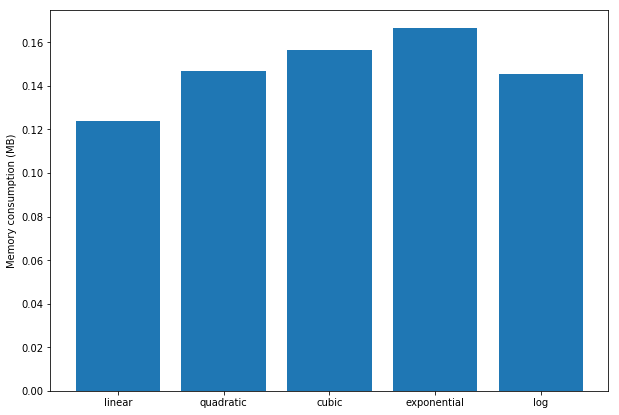

In [36]:
plt.figure(figsize=(10, 7))
plt.bar(np.arange(1, len(memory_consumption_MB) + 1, 1), memory_consumption_MB);
plt.xticks(np.arange(1, len(memory_consumption_MB) + 1, 1), total_memory.keys(), rotation='horizontal');
plt.ylabel('Memory consumption (MB)');

# Activations

In [41]:
start_bw = 12
a_scores = {}
opt_params_act = {}
acc_drop_a = {}

In [42]:
alloc_type = 'constant'

acc_drop_config = {
    layer: 0.005 for layer in layer_names
}
opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
a_scores[alloc_type], opt_params_act[alloc_type], acc_drop_a[alloc_type] = opts.run('activations', start_bw = start_bw)

{'conv2d_1': [12, 11], 'conv2d_2': [12, 8], 'conv2d_3': [12, 7], 'conv2d_4': [12, 8], 'conv2d_5': [12, 7], 'conv2d_6': [12, 7], 'conv2d_7': [12, 8], 'conv2d_8': [12, 7], 'conv2d_9': [12, 7], 'conv2d_10': [12, 7], 'conv2d_11': [12, 7], 'conv2d_12': [12, 6], 'conv2d_13': [12, 6], 'conv2d_14': [12, 6], 'dense_1': [12, 6]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer conv2d_1
(6, 6) (7, 7) 0.0016221477235859694
Chosen:  (7, 7)
After quantizing layer conv2d_1 | Measured accuracy drop 0.0 | Acceptable accuracy drop: 0.005
Quantizing layer conv2d_2
(4, 2) (5, 3) 0.0030280090840272785
Chosen:  (5, 3)
After quantizing layer conv2d_2 | Measured accuracy drop 0.0016221477235859694 | Acceptable accuracy drop: 0.005
Quantizing layer conv2d_3
(4, 1) (5, 2) 0.002487293176165209
Chosen:  (5, 2)
After quantizing layer conv2d_3 | Measured accuracy drop 0.0020547204498756492 | Acceptable accuracy drop: 0.005
Quantizing layer conv2d_4
(3, 0) (4, 1) 0.0

Floating point model accuracy: 92.470 %
Quantized model accuracy: 92.040 %
Accuracy drop of 0.465 %


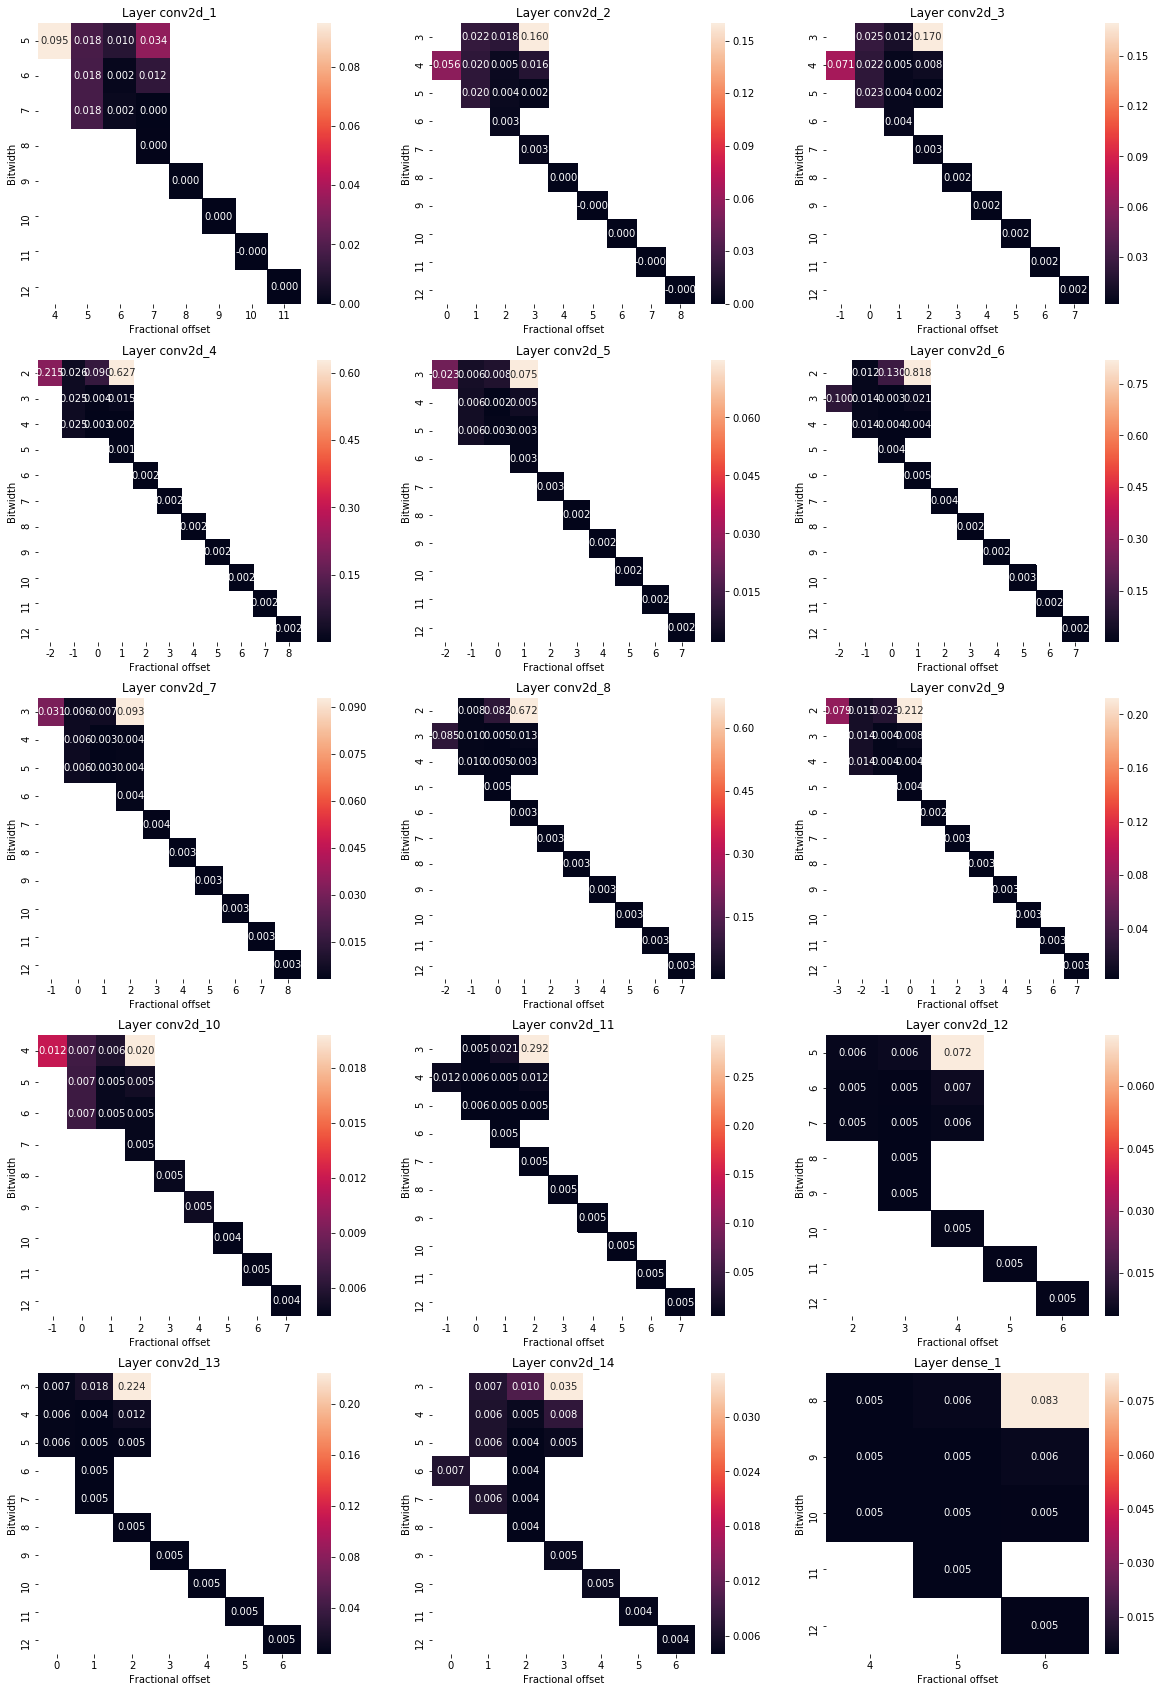

In [43]:
if not isinstance(opt_params_act[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act[alloc_type]))
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(a_scores[alloc_type], 5, 3, (20, 30))

### Log

In [44]:
alloc_type = 'log'

acc_drop_config = {
    layer_names[i - 1]: log(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
a_scores[alloc_type], opt_params_act[alloc_type], acc_drop_a[alloc_type] = opts.run('activations', start_bw = start_bw)

{'conv2d_1': [12, 11], 'conv2d_2': [12, 8], 'conv2d_3': [12, 7], 'conv2d_4': [12, 8], 'conv2d_5': [12, 7], 'conv2d_6': [12, 7], 'conv2d_7': [12, 8], 'conv2d_8': [12, 7], 'conv2d_9': [12, 7], 'conv2d_10': [12, 7], 'conv2d_11': [12, 7], 'conv2d_12': [12, 6], 'conv2d_13': [12, 6], 'conv2d_14': [12, 6], 'dense_1': [12, 6]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer conv2d_1
(10, 10) (11, 11) 0.00021628636314477998
Chosen:  (10, 10)
After quantizing layer conv2d_1 | Measured accuracy drop -0.0008651454525792397 | Acceptable accuracy drop: 0.0
Quantizing layer conv2d_2
(6, 3) (6, 3) 0.0
Chosen:  (6, 3)
After quantizing layer conv2d_2 | Measured accuracy drop 0.00032442954471716986 | Acceptable accuracy drop: 0.0012797901240490775
Quantizing layer conv2d_3
(6, 2) (7, 3) 0.0003244295447171699
Chosen:  (6, 2)
After quantizing layer conv2d_3 | Measured accuracy drop 0.0005407159078619498 | Acceptable accuracy drop: 0.002028419355411065
Quan

Floating point model accuracy: 92.470 %
Quantized model accuracy: 92.040 %
Accuracy drop of 0.465 %


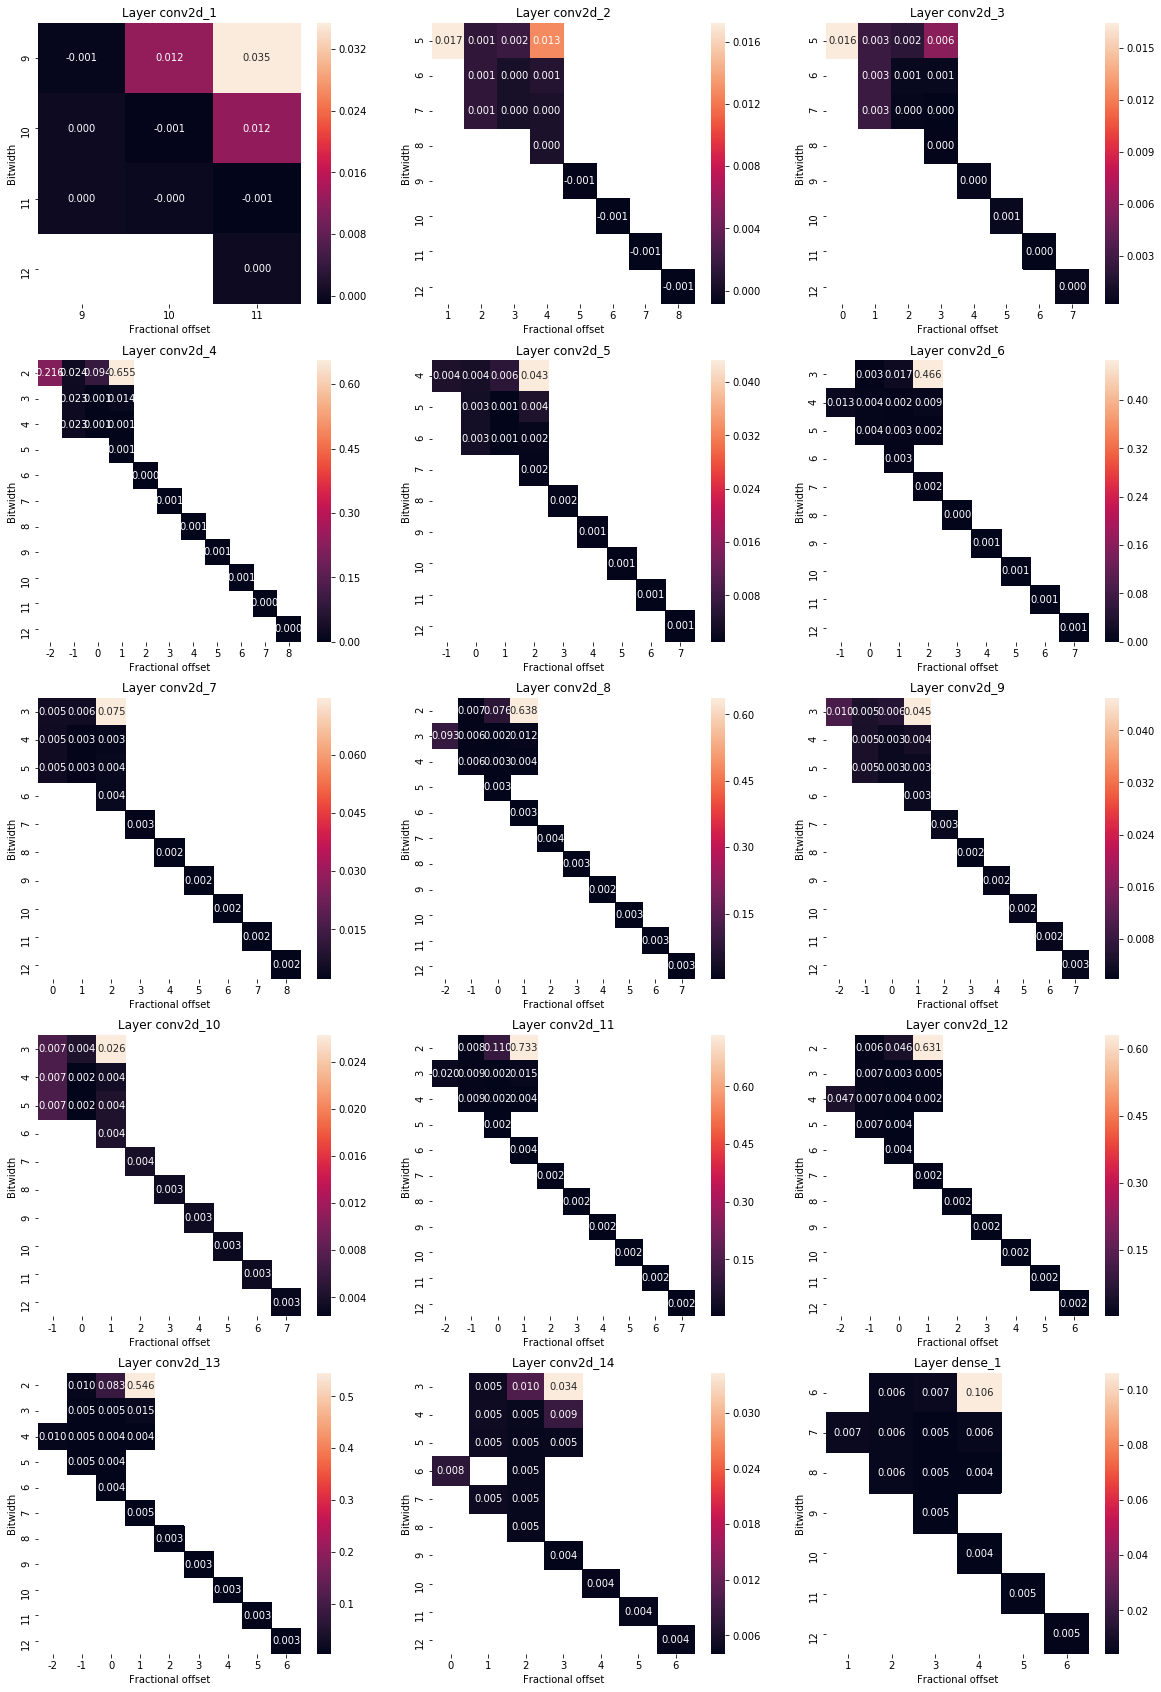

In [45]:
if not isinstance(opt_params_act[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act[alloc_type]))
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(a_scores[alloc_type], 5, 3, (20, 30))

#### Linear

In [46]:
alloc_type = 'linear'

acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
a_scores[alloc_type], opt_params_act[alloc_type], acc_drop_a[alloc_type] = opts.run('activations', start_bw = start_bw)

{'conv2d_1': [12, 11], 'conv2d_2': [12, 8], 'conv2d_3': [12, 7], 'conv2d_4': [12, 8], 'conv2d_5': [12, 7], 'conv2d_6': [12, 7], 'conv2d_7': [12, 8], 'conv2d_8': [12, 7], 'conv2d_9': [12, 7], 'conv2d_10': [12, 7], 'conv2d_11': [12, 7], 'conv2d_12': [12, 6], 'conv2d_13': [12, 6], 'conv2d_14': [12, 6], 'dense_1': [12, 6]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer conv2d_1
(8, 8) (8, 8) 0.0
Chosen:  (8, 8)
After quantizing layer conv2d_1 | Measured accuracy drop -0.0008651454525792397 | Acceptable accuracy drop: 0.0003333333333333333
Quantizing layer conv2d_2
(5, 3) (6, 3) 0.0012977181788687993
Chosen:  (5, 3)
After quantizing layer conv2d_2 | Measured accuracy drop 0.0006488590894343397 | Acceptable accuracy drop: 0.0006666666666666666
Quantizing layer conv2d_3
(7, 3) (7, 4) 0.0006488590894343397
Chosen:  (7, 4)
After quantizing layer conv2d_3 | Measured accuracy drop 0.0002162863631447799 | Acceptable accuracy drop: 0.001
Quantizin

Floating point model accuracy: 92.470 %
Quantized model accuracy: 92.130 %
Accuracy drop of 0.368 %


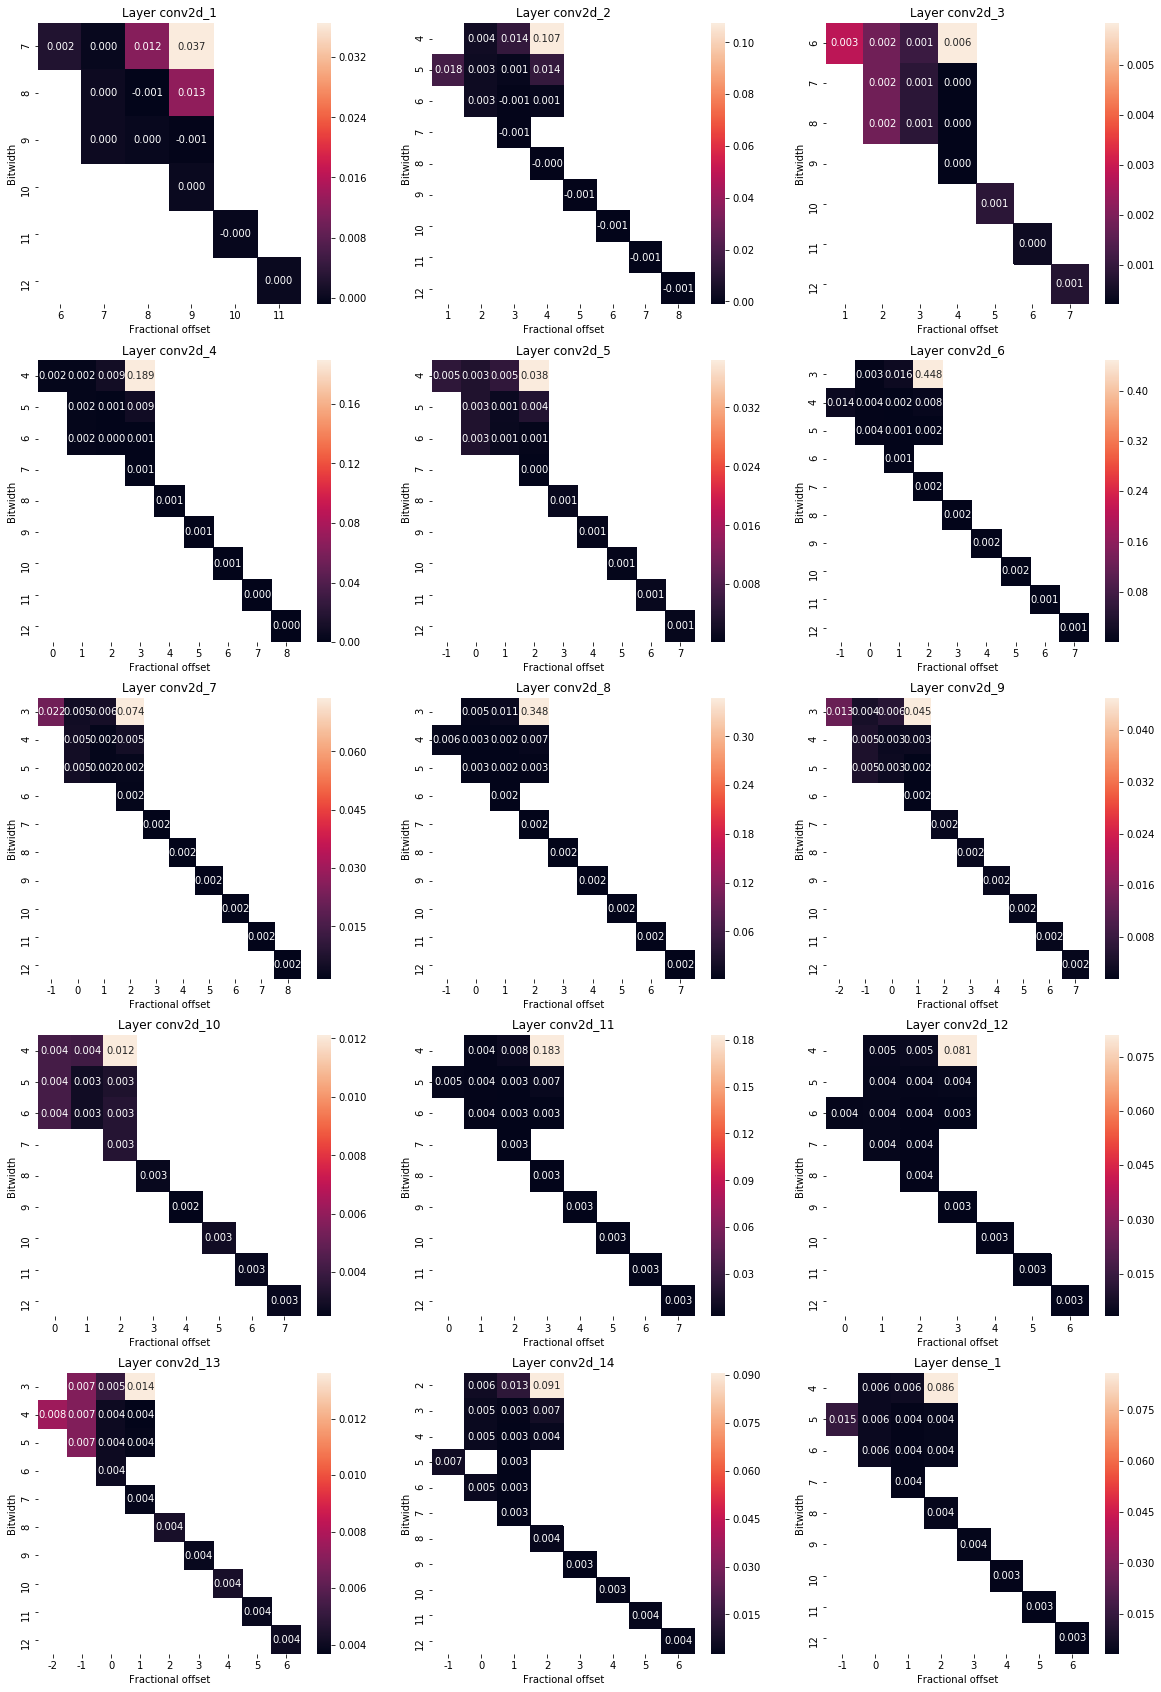

In [47]:
if not isinstance(opt_params_act[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act[alloc_type]))
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(a_scores[alloc_type], 5, 3, (20, 30))

#### Quadratic

In [48]:
alloc_type = 'quadratic'

acc_drop_config = {
    layer_names[i - 1]: quadratic(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
a_scores[alloc_type], opt_params_act[alloc_type], acc_drop_a[alloc_type] = opts.run('activations', start_bw = 16)

{'conv2d_1': [16, 15], 'conv2d_2': [16, 12], 'conv2d_3': [16, 11], 'conv2d_4': [16, 12], 'conv2d_5': [16, 11], 'conv2d_6': [16, 11], 'conv2d_7': [16, 12], 'conv2d_8': [16, 11], 'conv2d_9': [16, 11], 'conv2d_10': [16, 11], 'conv2d_11': [16, 11], 'conv2d_12': [16, 10], 'conv2d_13': [16, 10], 'conv2d_14': [16, 10], 'dense_1': [16, 10]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer conv2d_1
(13, 13) (12, 12) 0.00010814318157239004
Chosen:  (12, 12)
After quantizing layer conv2d_1 | Measured accuracy drop -0.0010814318157240197 | Acceptable accuracy drop: 2.2222222222222223e-05
Quantizing layer conv2d_2
(6, 3) (7, 4) 0.00010814318157238996
Chosen:  (6, 3)
After quantizing layer conv2d_2 | Measured accuracy drop -0.00021628636314489997 | Acceptable accuracy drop: 8.888888888888889e-05
Quantizing layer conv2d_3
(9, 5) (10, 6) 0.00010814318157238996
Chosen:  (9, 5)
After quantizing layer conv2d_3 | Measured accuracy drop -0.00021628636314489

Floating point model accuracy: 92.470 %
Quantized model accuracy: 92.030 %
Accuracy drop of 0.476 %


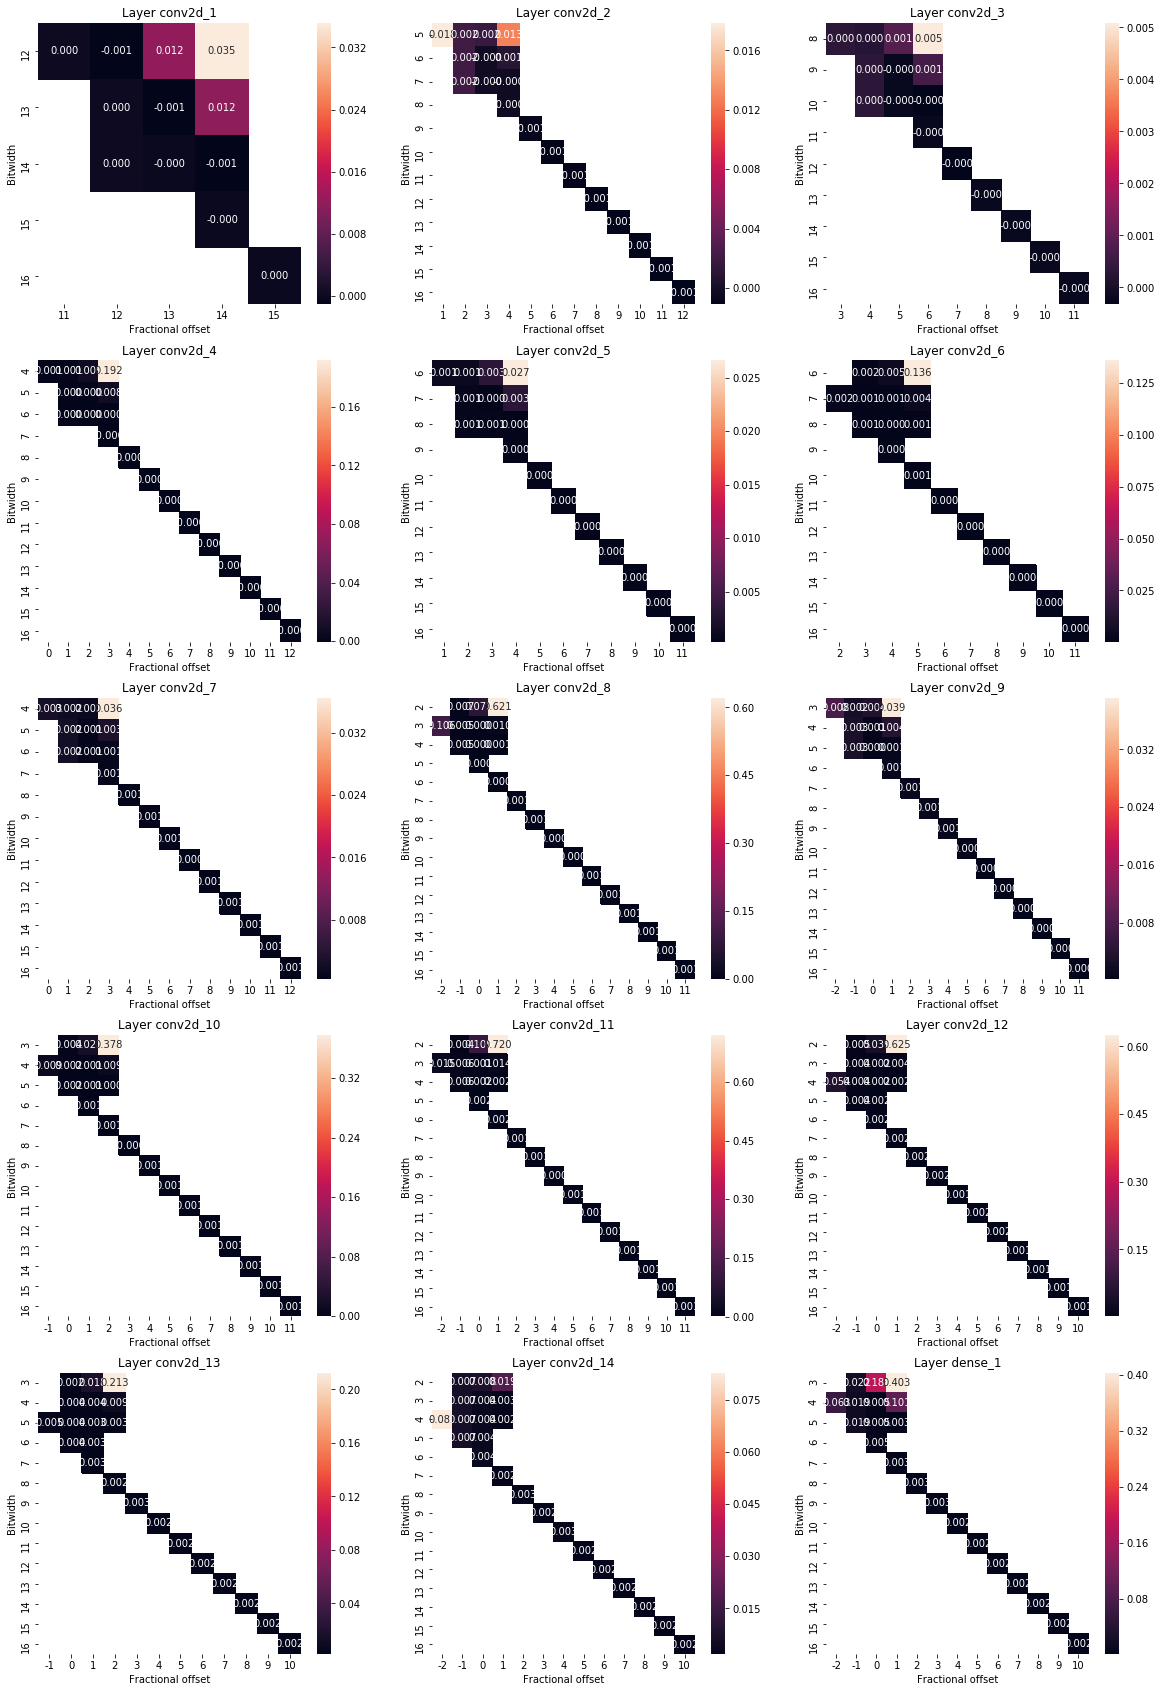

In [49]:
if not isinstance(opt_params_act[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act[alloc_type]))
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(a_scores[alloc_type], 5, 3, (20, 30))

### Cubic

In [50]:
alloc_type = 'cubic'
acc_drop_config = {
    layer_names[i - 1]: cubic(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
a_scores[alloc_type], opt_params_act[alloc_type], acc_drop_a[alloc_type] = opts.run('activations', start_bw = 16)

{'conv2d_1': [16, 15], 'conv2d_2': [16, 12], 'conv2d_3': [16, 11], 'conv2d_4': [16, 12], 'conv2d_5': [16, 11], 'conv2d_6': [16, 11], 'conv2d_7': [16, 12], 'conv2d_8': [16, 11], 'conv2d_9': [16, 11], 'conv2d_10': [16, 11], 'conv2d_11': [16, 11], 'conv2d_12': [16, 10], 'conv2d_13': [16, 10], 'conv2d_14': [16, 10], 'dense_1': [16, 10]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer conv2d_1
(13, 13) (12, 12) 0.00010814318157239004
Chosen:  (12, 12)
After quantizing layer conv2d_1 | Measured accuracy drop -0.0010814318157240197 | Acceptable accuracy drop: 1.4814814814814815e-06
Quantizing layer conv2d_2
(6, 3) (7, 4) 0.00010814318157238996
Chosen:  (6, 3)
After quantizing layer conv2d_2 | Measured accuracy drop -0.00021628636314489997 | Acceptable accuracy drop: 1.1851851851851852e-05
Quantizing layer conv2d_3
(9, 5) (10, 6) 0.00010814318157238996
Chosen:  (9, 5)
After quantizing layer conv2d_3 | Measured accuracy drop -0.0002162863631448

Floating point model accuracy: 92.470 %
Quantized model accuracy: 92.290 %
Accuracy drop of 0.195 %


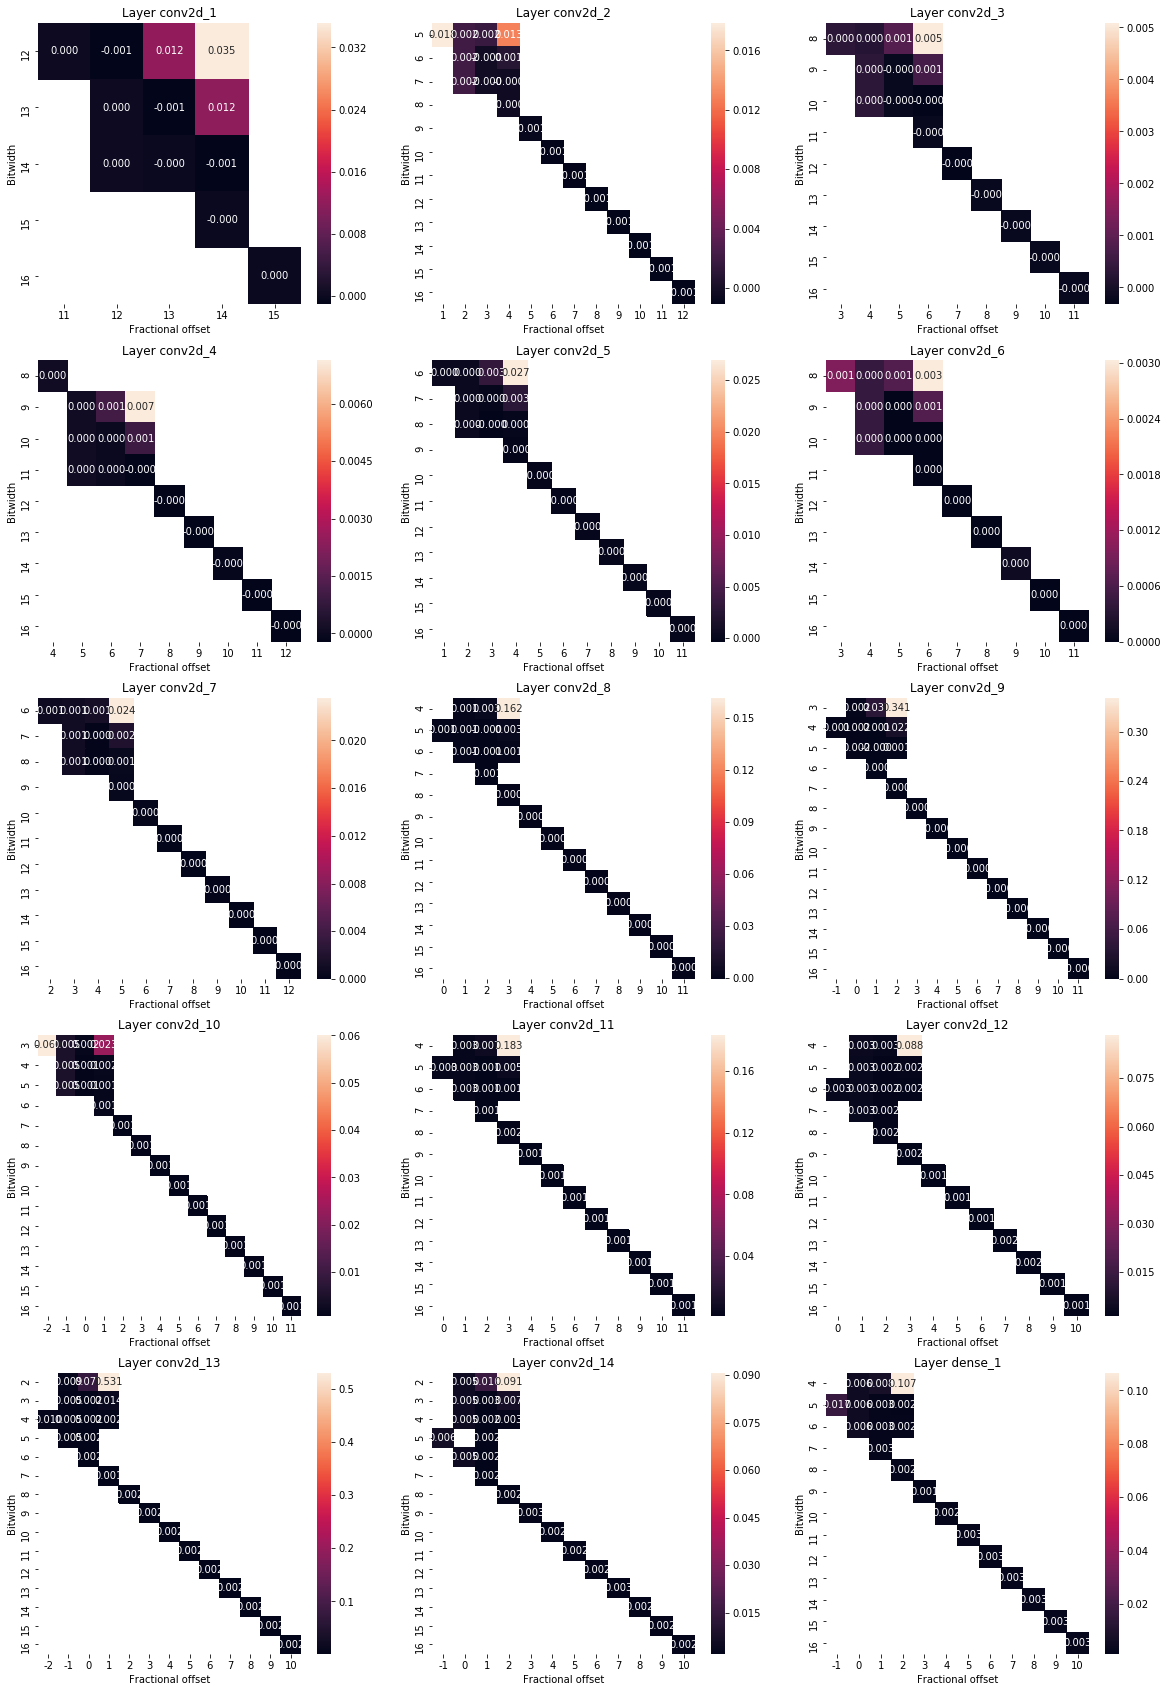

In [51]:
if not isinstance(opt_params_act[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act[alloc_type]))
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(a_scores[alloc_type], 5, 3, (20, 30))

### Exponential

In [52]:
alloc_type = 'exponential'

acc_drop_config = {
    layer_names[i - 1]: exponential(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
a_scores[alloc_type], opt_params_act[alloc_type], acc_drop_a[alloc_type] = opts.run('activations', start_bw = 16)

{'conv2d_1': [16, 15], 'conv2d_2': [16, 12], 'conv2d_3': [16, 11], 'conv2d_4': [16, 12], 'conv2d_5': [16, 11], 'conv2d_6': [16, 11], 'conv2d_7': [16, 12], 'conv2d_8': [16, 11], 'conv2d_9': [16, 11], 'conv2d_10': [16, 11], 'conv2d_11': [16, 11], 'conv2d_12': [16, 10], 'conv2d_13': [16, 10], 'conv2d_14': [16, 10], 'dense_1': [16, 10]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer conv2d_1
(13, 13) (12, 12) 0.00010814318157239004
Chosen:  (12, 12)
After quantizing layer conv2d_1 | Measured accuracy drop -0.0010814318157240197 | Acceptable accuracy drop: 3.0517578125e-07
Quantizing layer conv2d_2
(6, 3) (7, 4) 0.00010814318157238996
Chosen:  (6, 3)
After quantizing layer conv2d_2 | Measured accuracy drop -0.00021628636314489997 | Acceptable accuracy drop: 6.103515625e-07
Quantizing layer conv2d_3
(9, 5) (10, 6) 0.00010814318157238996
Chosen:  (9, 5)
After quantizing layer conv2d_3 | Measured accuracy drop -0.00021628636314489997 | Accept

Floating point model accuracy: 92.470 %
Quantized model accuracy: 92.510 %
Accuracy drop of -0.043 %


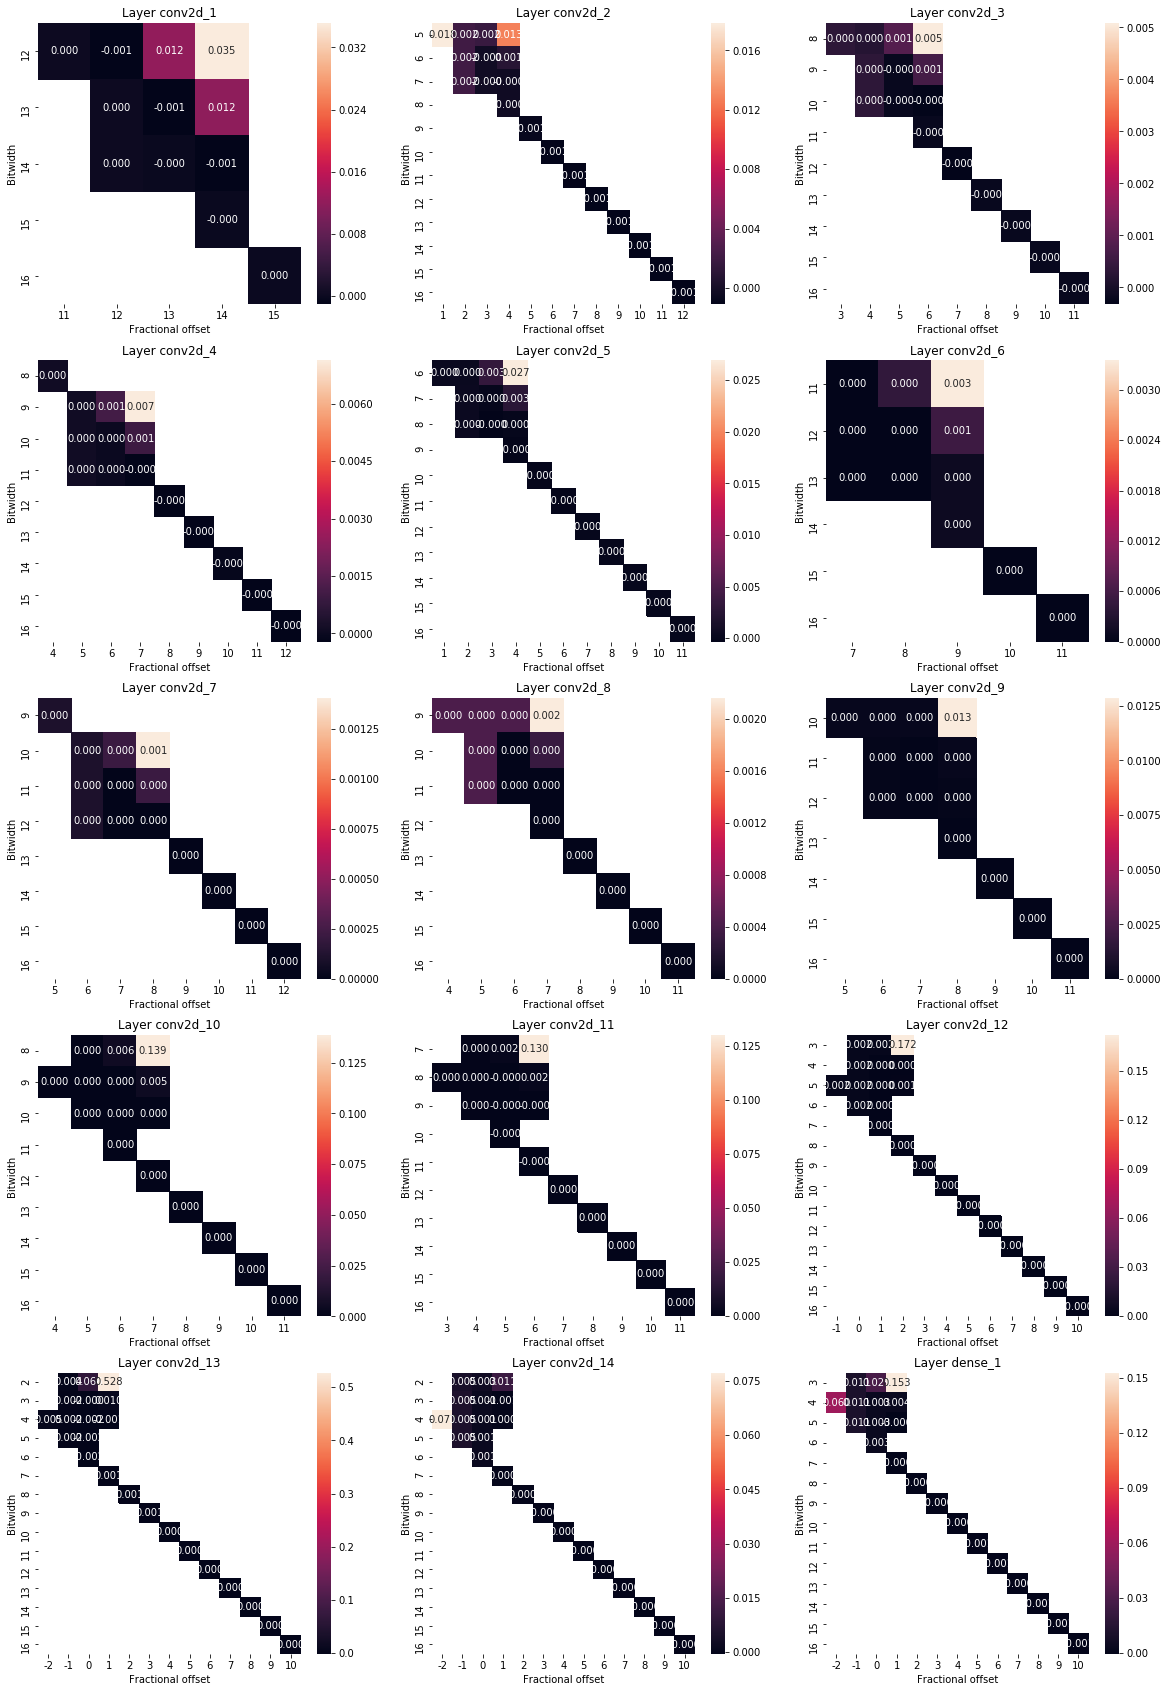

In [53]:
if not isinstance(opt_params_act[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act[alloc_type]))
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(a_scores[alloc_type], 5, 3, (20, 30))

In [54]:
with open(output_path + 'fixed/a_scores.p', 'wb') as f:
    pickle.dump(a_scores, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(output_path + 'fixed/opt_params_a.p', 'wb') as f:
    pickle.dump(opt_params_act, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(output_path + 'fixed/acc_drop_a.p', 'wb') as f:
    pickle.dump(acc_drop_a, f, protocol=pickle.HIGHEST_PROTOCOL)

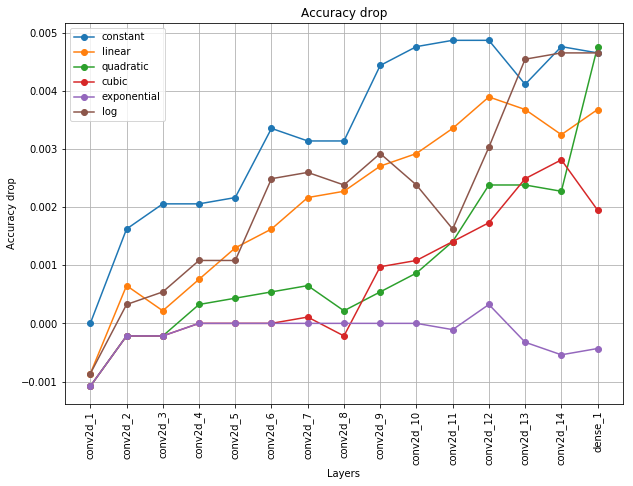

In [55]:
## Accuracy drop
x = np.arange(1, len(layer_names) + 1, 1)

plt.figure(figsize=(10, 7))
for k in acc_drop_w:
    plt.plot(x, acc_drop_a[k].values(), 'o-', label=k)
plt.title('Accuracy drop');
plt.xlabel('Layers');
plt.ylabel('Accuracy drop');
plt.xticks(x, layer_names, rotation='vertical')
plt.grid()
plt.legend();

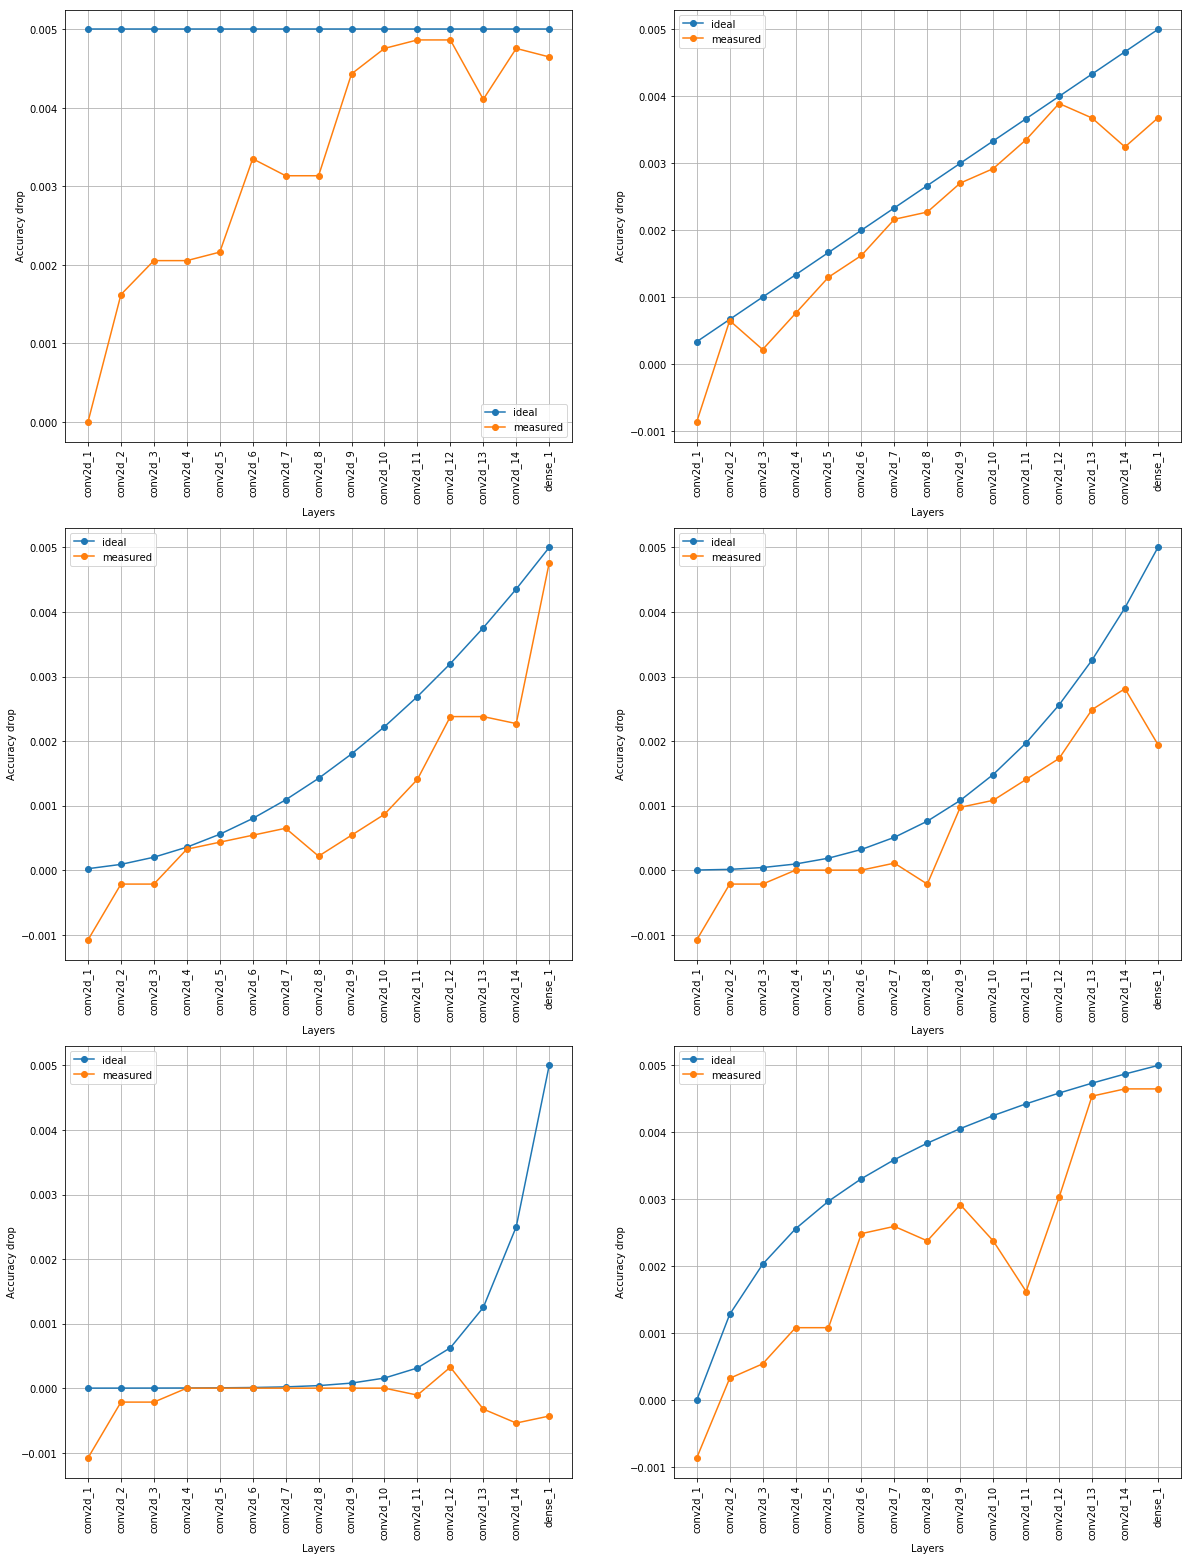

In [56]:
x = np.arange(1, 16, 1)
num_layers = len(x)
n = 0.005 # loss of 0.5%
y1 = np.ones(x.shape) * n # constant
y2 = n/num_layers * x
y3 = n/num_layers**2 * x**2 # Quadratic
y4 = n/num_layers**3 * x**3 # Cubic
y5 = n/2**num_layers * 2**x # Exponential
y6 = n/np.log(num_layers) * np.log(x) # log

fig, axes = plt.subplots(3, 2, figsize=(20, 27))
ax = axes.flatten()
ax[0].plot(x, y1, 'o-', label='ideal');
ax[0].plot(x, acc_drop_a['constant'].values(), 'o-', label='measured');

ax[1].plot(x, y2, 'o-', label='ideal');
ax[1].plot(x, acc_drop_a['linear'].values(), 'o-', label='measured');

ax[2].plot(x, y3, 'o-', label='ideal');
ax[2].plot(x, acc_drop_a['quadratic'].values(), 'o-', label='measured');

ax[3].plot(x, y4, 'o-', label='ideal');
ax[3].plot(x, acc_drop_a['cubic'].values(), 'o-', label='measured');

ax[4].plot(x, y5, 'o-', label='ideal');
ax[4].plot(x, acc_drop_a['exponential'].values(), 'o-', label='measured');

ax[5].plot(x, y6, 'o-', label='ideal');
ax[5].plot(x, acc_drop_a['log'].values(), 'o-', label='measured');

for i in range(6):
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(layer_names, rotation=90)
    # plt.title('Accuracy drop');
    ax[i].set_xlabel('Layers');
    ax[i].set_ylabel('Accuracy drop');
    ax[i].grid();
    ax[i].legend();

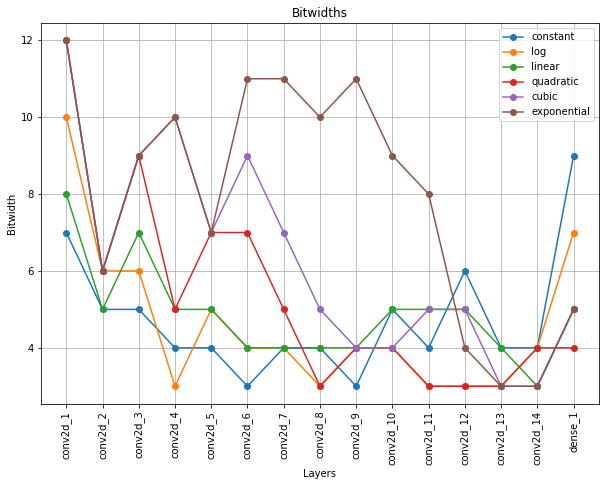

In [57]:
## Bitwidths
x = np.arange(1, len(layer_names) + 1, 1)

plt.figure(figsize=(10, 7))
for k in opt_params_act:
    bw = [opt_params_act[k][layer][0] for layer in opt_params_act[k]]
    plt.plot(x, bw, 'o-', label=k)
plt.xticks(x, layer_names, rotation='vertical')
plt.title('Bitwidths')
plt.xlabel('Layers');
plt.ylabel('Bitwidth');
plt.grid()
plt.legend();

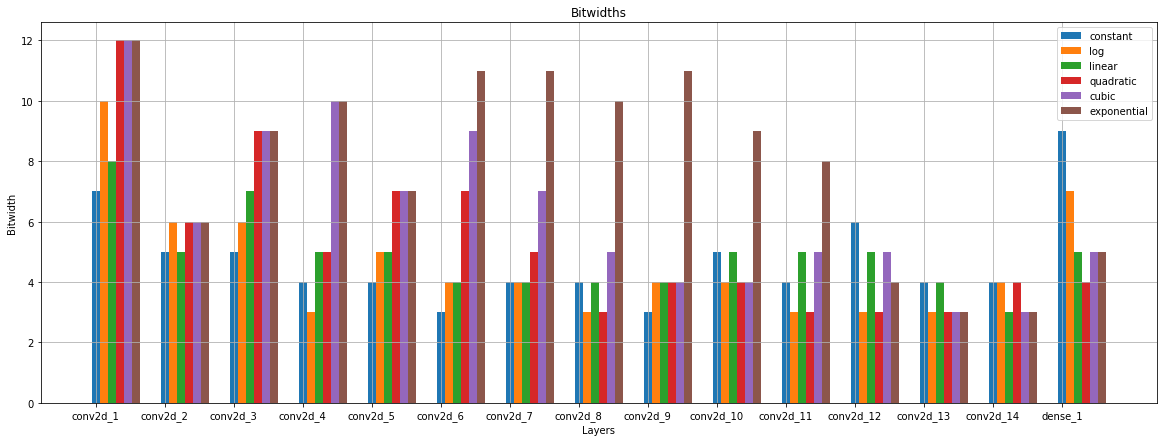

In [58]:
plt.figure(figsize=(20, 7))
width = 0.35
x = np.arange(1, 3*len(layer_names) + 1, 3)
for j, k in enumerate(opt_params_act.keys()):
    bw = [opt_params_act[k][layer][0] for layer in opt_params_act[k]]
    plt.bar([i + j*width for i in x], bw, width, label=k)
plt.xticks(x, layer_names, rotation='horizontal')
plt.title('Bitwidths')
plt.xlabel('Layers');
plt.ylabel('Bitwidth');
plt.grid()
plt.legend();

In [ ]:
# for layer in model_obj.model.layers:
#     if layer.weights and layer.name.startswith('conv2d') or layer.name.startswith('dense'):
#         print(layer.input_shape[1:], layer.output_shape[1:])